In [419]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import NA, NaT

# Exploracion directo del db

### Bajar los datos de la db

In [420]:
from pymongo import MongoClient
client = MongoClient('localhost', 27017)
db=client["db_pasanti"]
#db.drop_collection()
data= db.signals.find()
list_data = list(data)


ServerSelectionTimeoutError: localhost:27017: [Errno 111] Connection refused, Timeout: 30s, Topology Description: <TopologyDescription id: 62cc180705ffb137d90c8d64, topology_type: Single, servers: [<ServerDescription ('localhost', 27017) server_type: Unknown, rtt: None, error=AutoReconnect('localhost:27017: [Errno 111] Connection refused')>]>

In [ ]:
df = pd.DataFrame(list_data)
df.columns

Index(['_id', 'symbol_message', 'symbol', 'currencies', 'is_future', 'is_long',
       'leverage', 'percent_amount', 'is_entry_market', 'entry_targets',
       'take_profit_targets', 'stop_targets', 'trailing_configuration',
       'quantity', 'quantity_take_profit', 'free', 'timeStamp_Tg', 'date',
       'message_id', 'channel', 'channel_id', 'message_link', 'dates_entry',
       'dates_stoploss', 'dates_profit', 'efficiency', 'forecast_trend',
       'day_value', 'trend_day', 'best_params', 'ta_recomendation',
       'error_ta_recomendation', 'score', 'error_prophettesting',
       'error_backtesting'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1554 entries, 0 to 1553
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   _id                     1554 non-null   object        
 1   symbol_message          1554 non-null   object        
 2   symbol                  1554 non-null   object        
 3   currencies              1554 non-null   object        
 4   is_future               1554 non-null   bool          
 5   is_long                 1554 non-null   bool          
 6   leverage                1554 non-null   object        
 7   percent_amount          1554 non-null   int64         
 8   is_entry_market         1554 non-null   bool          
 9   entry_targets           1554 non-null   object        
 10  take_profit_targets     1554 non-null   object        
 11  stop_targets            1554 non-null   object        
 12  trailing_configuration  1554 non-null   object  

### FILTRAR CAMPOS INNECESARIOS

##### Columnas originales

In [ ]:
columnas=list(df.columns)
columnas

['_id',
 'symbol_message',
 'symbol',
 'currencies',
 'is_future',
 'is_long',
 'leverage',
 'percent_amount',
 'is_entry_market',
 'entry_targets',
 'take_profit_targets',
 'stop_targets',
 'trailing_configuration',
 'quantity',
 'quantity_take_profit',
 'free',
 'timeStamp_Tg',
 'date',
 'message_id',
 'channel',
 'channel_id',
 'message_link',
 'dates_entry',
 'dates_stoploss',
 'dates_profit',
 'efficiency',
 'forecast_trend',
 'day_value',
 'trend_day',
 'best_params',
 'ta_recomendation',
 'error_ta_recomendation',
 'score',
 'error_prophettesting',
 'error_backtesting']

##### Columnas usadas

In [ ]:
columnas=['_id',
 'symbol',
 'currencies',
 'is_long',
 'leverage',
 'is_entry_market',
 'entry_targets',
 'take_profit_targets',
 'stop_targets',
 'trailing_configuration',
 'date',
 'channel',
 'channel_id',
 'message_link',
 'dates_entry',
 'dates_stoploss',
 'dates_profit',
 'efficiency',
 'ta_recomendation',
 'forecast_trend',
 'day_value',
 'trend_day',
 'best_params',
 'score',
 'error_ta_recomendation',
 'error_prophettesting',
 'error_backtesting']

In [ ]:
# Tamaño original
df_sygnals=df[columnas].copy()
df[columnas].shape

(1554, 27)

### Buscar si hay diferentes entre message symbol y symbol

In [ ]:
df[df["symbol_message"]!=df["symbol"]].loc[:,["symbol_message","symbol","channel"]]
# Solo hay diferencia en un canal y es por que contiene "/", por lo que podemos quitar el "symbol_message"

,symbol_message,symbol,channel
0,BCH/USDT,BCHUSDT,Crypto Futures Spot Signals😘
1,ETH/USDT,ETHUSDT,Crypto Futures Spot Signals😘
2,BTC/USDT,BTCUSDT,Crypto Futures Spot Signals😘
3,BTC/USDT,BTCUSDT,Crypto Futures Spot Signals😘
4,BZRX/USDT,BZRXUSDT,Crypto Futures Spot Signals😘
...,...,...,...
523,BAL/USDT,BALUSDT,Crypto Futures Spot Signals😘
524,BLZ/USDT,BLZUSDT,Crypto Futures Spot Signals😘
525,TLM/USDT,TLMUSDT,Crypto Futures Spot Signals😘
526,LRC/USDT,LRCUSDT,Crypto Futures Spot Signals😘


### Extraer los "currencies",'leverage','trailing_configuration' y crear nuevos campos con ellos

In [ ]:
campos=["currencies",
 'leverage',
 'trailing_configuration',
]
for campo in campos:
    for key in df_sygnals[campo][0].keys():# Ve las keys existentes en el campo
        extraer=lambda x : x[key] # por diccionario en el campo extrae los valores con las keys
        df_sygnals[key+"_"+campo]=df_sygnals[campo].agg(extraer) # construye la columna con el nombre de la Key + el campo
df_sygnals.drop(axis=1,labels=campos,inplace=True) # elimina el campo extraido

# aplicable para campos que no contienen NaN

### Extraer los ta_recomendation y crear nuevos campo con ellos

In [ ]:
def extraer(x: dict,key):
    if type(x) == type(np.nan):
        return np.nan

    elif type(x[key])==type(np.nan):
        return np.nan

    elif type(x[key])!=type(np.nan):
        return x[key]

    # aplicable para campos que si contienen NaN

In [ ]:
keys= list(df_sygnals["ta_recomendation"][0].keys())
for key in keys:
    df_sygnals[key] = df_sygnals["ta_recomendation"].agg(lambda x : extraer(x,key))
df_sygnals.drop(axis=1,labels="ta_recomendation",inplace=True)

### sacar la columna "quantity_trailing_configuration"

In [ ]:
df_sygnals.drop(axis=1,labels="quantity_trailing_configuration",inplace=True)

### sacar valor de eficiencia

In [ ]:
df_sygnals["efficiency"] = df_sygnals["efficiency"].agg(lambda x: list(x.values())[0]*100 if type(x) != float and type(x) != int else x )

### Extraer primeras fechas de los EPS_dates

In [ ]:
def first_date(x:dict):
    if x != False and x is not np.nan:
        temp_list=list(set(x.values()))
        if False in temp_list:    
            temp_list.remove(False)
        if temp_list==[]:
            temp_list.append("never")
        temp_list.sort()

        return temp_list[0]
    return x

In [ ]:
campos=['dates_entry',
 'dates_stoploss',
 'dates_profit']
for campo in campos:
    df_sygnals["first"+"_"+campo]=df_sygnals[campo].agg(lambda x: first_date(x))
#df_sygnals.drop(axis=1,labels=campos,inplace=True)

#### Extraer ultimas fechas de los E_dates

In [ ]:
def last_date(x:dict):
    if x != False and x is not np.nan:
        temp_list=list(set(x.values()))
        if False in temp_list:    
            temp_list.remove(False)
        if temp_list==[]:
            temp_list.append("never")
        temp_list.sort()

        return temp_list[-1]
    return x

In [ ]:
campos=['dates_entry']
for campo in campos:
    df_sygnals["Last"+"_"+campo]=df_sygnals[campo].agg(lambda x: last_date(x))

In [ ]:
df_sygnals["Last_dates_entry"][df_sygnals["Last_dates_entry"]!=False]

6       2022-05-12 03:10:00
20      2021-03-12 09:10:00
26      2021-03-15 20:30:00
28      2021-03-12 16:10:00
30      2021-03-13 06:15:00
               ...         
1548    2022-06-13 21:55:00
1549    2022-06-18 15:45:00
1550    2022-06-18 15:35:00
1551    2022-06-18 03:15:00
1553    2022-06-18 15:45:00
Name: Last_dates_entry, Length: 1320, dtype: object

### Extraer los best params y crear sus campos

In [ ]:
# aplicable con numeros

def extraer(x: dict,key):
    if x is np.nan:
        return np.nan

    elif x[key] is np.nan:
         return np.nan

    return x[key]

In [ ]:
# np.NaN es un float, no se detecta igualandolos pero si revisando si está en la misma memoria.
(type(np.nan),
 df_sygnals["best_params"].loc[4] is np.nan,
 df_sygnals["best_params"].loc[4] == np.nan,
 type(NA),
 type(NA==np.nan),
 NaT is np.nan,
 )

(float,
 True,
 False,
 pandas._libs.missing.NAType,
 pandas._libs.missing.NAType,
 False)

In [ ]:

columns=["best_params"]
for column in columns:
    keys= list(df_sygnals[column][0].keys())
    for key in keys:
        df_sygnals[key+"_bp"] = df_sygnals[column].agg(lambda x : extraer(x,key))
    #df_sygnals.drop(axis=1,labels=column,inplace=True)

### Extraer los score y crear sus campos, Vigilar el prophet testing

In [ ]:
mask=~df_sygnals["score"].isna()

In [ ]:
(df_sygnals['changepoint_prior_scale_bp'][mask].value_counts(),
df_sygnals['seasonality_prior_scale_bp'][mask].value_counts(),
df_sygnals['seasonality_mode_bp'][mask].value_counts())

(0.05    549
 2.50    474
 0.50      6
 Name: changepoint_prior_scale_bp, dtype: int64,
 0.01     562
 10.00    446
 0.10      11
 1.00      10
 Name: seasonality_prior_scale_bp, dtype: int64,
 additive          534
 multiplicative    495
 Name: seasonality_mode_bp, dtype: int64)

In [ ]:
# Revisando los mejores parametros y los prophet testing realizados hasta el momento

(
df_sygnals['changepoint_prior_scale_bp'][mask].unique(),
df_sygnals['seasonality_prior_scale_bp'][mask].unique(),
df_sygnals['seasonality_mode_bp'][mask].unique(),
df_sygnals['symbol'][mask].unique(),
df_sygnals[mask].shape,

)

(array([0.05, 2.5 , 0.5 ]),
 array([ 0.01, 10.  ,  1.  ,  0.1 ]),
 array(['multiplicative', 'additive'], dtype=object),
 array(['BCHUSDT', 'ETHUSDT', 'IOTAUSDT', 'BZRXUSDT', 'ATOMBTC', 'FETBTC',
        'ARPABTC', 'LTCUSDT', 'BLZUSDT', 'FLMUSDT', 'ALGOUSDT', 'ENJUSDT',
        'AVAXBTC', 'MANAUSDT', 'CTKUSDT', 'BATUSDT', 'LTOUSDT', 'BELUSDT',
        'AKROUSDT', 'LINKUSDT', 'LITUSDT', 'EGLDBTC', 'ADAUSDT',
        'MATICUSDT', 'BANDUSDT', 'COMPUSDT', 'ATMUSDT', 'ATOMUSDT',
        'NEOUSDT', 'MANABTC', 'DOTUSDT', 'ETCUSDT', 'FETUSDT', 'FTTUSDT',
        'DOGEUSDT', 'EOSUSDT', 'CRVUSDT', 'BNBUSDT', 'GXSBTC', 'CVCBTC',
        'ANKRBTC', 'GRTUSDT', 'NEARUSDT', 'AAVEUSDT', 'INJBTC', 'NASBTC',
        'ALPHAUSDT', 'IRISBTC', 'KAVAUSDT', 'EGLDUSDT', 'HNTUSDT',
        'CVCUSDT', 'DIABTC', 'IDEXBTC', 'NEBLBTC', 'BANDBTC', 'COMPBTC',
        'BNBBTC', 'AXSUSDT', 'LUNAUSDT', 'EPSBTC', 'BZRXBTC', 'APPCBTC',
        'CHRUSDT', 'ALICEUSDT', 'BTTUSDT', 'IOTABTC', 'CRVBTC', 'EVXBTC',
        'ADXBT

In [ ]:
# aplicable con numeros

def extraer(x: dict,key):

    if x is np.nan:
        return np.nan

    elif x[key] is np.nan:
         return np.nan

    return x[key]

In [ ]:
columns=["score"]
for column in columns:
    keys= list(df_sygnals[mask][column].iloc[0].keys())
    for key in keys:
        df_sygnals[key+"_bp"] = df_sygnals[column].agg(lambda x : extraer(x,key))
    #df_sygnals.drop(axis=1,labels=column,inplace=True)

### Extraer porcentajes de stop loss con respecto a primera entrada

In [ ]:
def stoploss_ave(entry,stop,is_long):
    
    if entry!=[] and type(entry)!=float:
    
        
        entry_v=max(entry)
        
        if is_long:
            entry_v=min(entry)
    

    # return int(round((abs(entry_v-stop)/(entry_v)*100)))
    return "{0:.1f}".format(abs(entry_v-stop)/(entry_v)*100)

In [ ]:
df_sygnals[["entry_targets","stop_targets","is_long", "message_link"]].loc[2]

entry_targets                  [11030.0, 11065.0, 11100.0]
stop_targets                                     [11190.0]
is_long                                              False
message_link     https://t.me/VIP_Futures_Spot_Signals/321
Name: 2, dtype: object

In [ ]:
df_sygnals["av_stoploss"]=df_sygnals[["entry_targets","stop_targets","is_long"]].agg(lambda x: stoploss_ave(x["entry_targets"],x["stop_targets"][0],x["is_long"]), axis=1)

In [ ]:
df_sygnals["av_stoploss"]

0         3.0
1         3.0
2         0.8
3         4.5
4         8.3
        ...  
1549     13.0
1550     11.6
1551     14.6
1552    100.0
1553     14.1
Name: av_stoploss, Length: 1554, dtype: object

### Extraer porcentajes de profit con respecto a primera entrada

In [ ]:
def profit_ave(entry:list,profit:list,is_long):
    
    #print(f"Entrada: {type(entry)}, Ganancias: {type(profit)} ")
    
    if (entry!=[] and profit!=[]) and (type(entry)!=float and type(profit)!=float):
    
        
        entry_v=max(entry)
        profit_v=max(profit)
        
        if is_long:
            entry_v=min(entry)
            profit_v=min(profit)
    
        return "{0:.1f}".format((abs(entry_v-profit_v)/(entry_v))*100)

    return np.nan

In [ ]:
### Requiero capturar la entrada mas baja si es long y la mas alta si es short
df_sygnals[["dates_entry"]].loc[37][0]

{'2.9501': datetime.datetime(2021, 3, 24, 16, 30),
 '2.7': datetime.datetime(2021, 3, 24, 18, 25)}

In [ ]:
df_sygnals["av_profit"]=df_sygnals[["entry_targets","take_profit_targets","is_long"]].agg(lambda x: profit_ave(x["entry_targets"],x["take_profit_targets"],x["is_long"]), axis=1)

In [ ]:
df_sygnals[["av_profit","efficiency"]].sort_values("av_profit").head(20)

,av_profit,efficiency
217,0.4,0.0
35,0.4,0.0
103,0.4,0.0
41,0.4,0.0
182,0.4,0.0
176,0.4,0.0
165,0.5,0.0
177,0.5,0.0
32,0.5,100.0
174,0.5,0.0


In [ ]:
# mask=df_sygnals["av_profit"]==df_sygnals["av_profit"].max()

In [ ]:
entry_v=55000.0
profit_v=55220.0
(entry_v-profit_v)/(entry_v)*100

-0.4

In [ ]:
df_sygnals[["is_long","entry_targets","take_profit_targets","av_profit","efficiency","channel"]].sort_values("av_profit",ascending=True)

,is_long,entry_targets,take_profit_targets,av_profit,efficiency,channel
217,False,[0.8939],"[0.8904, 0.887, 0.883, 0.876, 0.858]",0.4,0.0,Crypto Futures Spot Signals😘
35,True,[530.0],"[532.0, 535.0, 542.0, 555.0]",0.4,0.0,Crypto Futures Spot Signals😘
103,True,[16.55],"[16.615, 16.715, 16.96, 17.47]",0.4,0.0,Crypto Futures Spot Signals😘
41,True,[55000.0],"[55220.0, 55550.0, 56270.0, 57700.0]",0.4,0.0,Crypto Futures Spot Signals😘
182,False,[37720.0],"[37580.0, 37350.0, 36840.0, 35900.0]",0.4,0.0,Crypto Futures Spot Signals😘
...,...,...,...,...,...,...
1352,True,"[0.1015, 0.5307499999999999, 0.96]","[1.03, 1.05, 1.08, 1.12, 1.18, 1.26, 1.36, 1.4...",914.8,0.0,Federal Russian Insiders VIP Free
413,True,"[8.3, 7.8]","[15.0, 23.5, 34.0, 46.0]",92.3,0.0,Crypto Futures Spot Signals😘
881,False,"[0.4915, 24.868624999999998, 49.24575, 73.6228...","[0.4853, 0.4815, 0.4745]",99.5,0.0,𝑪𝒐𝒊𝒏|𝑪𝒐𝒂𝒄𝒉|𝑺𝒊𝒈𝒏𝒂𝒍𝒔
888,True,"[29769.3, 29844.475, 29919.65, 29994.825, 3007...","[20.0, 35.0, 45.0]",99.9,100.0,𝑪𝒐𝒊𝒏|𝑪𝒐𝒂𝒄𝒉|𝑺𝒊𝒈𝒏𝒂𝒍𝒔


### extraer cantidad de entradas y cantidad de profits

In [ ]:
df_sygnals["profit_count"]=df_sygnals[["take_profit_targets"]].agg(lambda x: len(*x),axis=1)
df_sygnals["entry_count"]=df_sygnals[["entry_targets"]].agg(lambda x: len(*x),axis=1)

### Guardar CSV y Pickle del df_sygnal

In [ ]:
df_sygnals.columns

Index(['_id', 'symbol', 'is_long', 'is_entry_market', 'entry_targets',
       'take_profit_targets', 'stop_targets', 'date', 'channel', 'channel_id',
       'message_link', 'dates_entry', 'dates_stoploss', 'dates_profit',
       'efficiency', 'forecast_trend', 'day_value', 'trend_day', 'best_params',
       'score', 'error_ta_recomendation', 'error_prophettesting',
       'error_backtesting', 'primary_currencies', 'segundary_currencies',
       'type_leverage', 'is_cross_leverage', 'percent_leverage',
       'percent_trailing_configuration', 'AO', 'RSI', 'ADX', 'CCI20', 'Stoch',
       'first_dates_entry', 'first_dates_stoploss', 'first_dates_profit',
       'Last_dates_entry', 'changepoint_prior_scale_bp',
       'seasonality_prior_scale_bp', 'seasonality_mode_bp', 'mae_bp',
       'rmse_bp', 'mape_bp', 'av_stoploss', 'av_profit', 'profit_count',
       'entry_count'],
      dtype='object')

In [ ]:
df_sygnals.drop(axis=1,inplace=True,columns=['entry_targets',
       'take_profit_targets', 'stop_targets','best_params',
       'score','Last_dates_entry'])

In [ ]:
df_sygnals.to_csv("pasanti_sygnals.csv")

In [ ]:
df_sygnals.to_pickle("pasanti_sygnals.pickle")

# Exploracion con el CSV o Pickle

### Leer .csv pasanti

In [ ]:
df_pasanti_sygnals=pd.read_csv("pasanti_sygnals.csv")

In [ ]:
df_sygnals=df_pasanti_sygnals.copy()
df_sygnals.drop(columns="Unnamed: 0",inplace=True)

In [ ]:
df_sygnals.columns

Index(['_id', 'symbol', 'is_long', 'is_entry_market', 'date', 'channel',
       'channel_id', 'message_link', 'dates_entry', 'dates_stoploss',
       'dates_profit', 'efficiency', 'forecast_trend', 'day_value',
       'trend_day', 'error_ta_recomendation', 'error_prophettesting',
       'error_backtesting', 'primary_currencies', 'segundary_currencies',
       'type_leverage', 'is_cross_leverage', 'percent_leverage',
       'percent_trailing_configuration', 'AO', 'RSI', 'ADX', 'CCI20', 'Stoch',
       'first_dates_entry', 'first_dates_stoploss', 'first_dates_profit',
       'changepoint_prior_scale_bp', 'seasonality_prior_scale_bp',
       'seasonality_mode_bp', 'mae_bp', 'rmse_bp', 'mape_bp', 'av_stoploss',
       'av_profit', 'profit_count', 'entry_count'],
      dtype='object')

In [ ]:
df_pasanti_sygnals["message_link"]

0         https://t.me/VIP_Futures_Spot_Signals/203
1         https://t.me/VIP_Futures_Spot_Signals/281
2         https://t.me/VIP_Futures_Spot_Signals/321
3         https://t.me/VIP_Futures_Spot_Signals/333
4         https://t.me/VIP_Futures_Spot_Signals/352
                           ...                     
1549    https://t.me/FedRussianInsidersFreeVIP/2614
1550    https://t.me/FedRussianInsidersFreeVIP/2621
1551    https://t.me/FedRussianInsidersFreeVIP/2628
1552    https://t.me/FedRussianInsidersFreeVIP/2635
1553    https://t.me/FedRussianInsidersFreeVIP/2636
Name: message_link, Length: 1554, dtype: object

### Ajustar los tipos de datos

In [ ]:
# determinar que tipo de datos hay en el data frame.
df_sygnals.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1554 entries, 0 to 1553
Data columns (total 42 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   _id                             1554 non-null   object 
 1   symbol                          1554 non-null   object 
 2   is_long                         1554 non-null   bool   
 3   is_entry_market                 1554 non-null   bool   
 4   date                            1554 non-null   object 
 5   channel                         1554 non-null   object 
 6   channel_id                      1554 non-null   int64  
 7   message_link                    1554 non-null   object 
 8   dates_entry                     1544 non-null   object 
 9   dates_stoploss                  1544 non-null   object 
 10  dates_profit                    1544 non-null   object 
 11  efficiency                      1544 non-null   float64
 12  forecast_trend                  10

In [ ]:
# convertir los datos tipo str a un typo de dato mas adecuado
df_sygnals=df_sygnals.convert_dtypes()

In [ ]:
df_sygnals.columns

Index(['_id', 'symbol', 'is_long', 'is_entry_market', 'date', 'channel',
       'channel_id', 'message_link', 'dates_entry', 'dates_stoploss',
       'dates_profit', 'efficiency', 'forecast_trend', 'day_value',
       'trend_day', 'error_ta_recomendation', 'error_prophettesting',
       'error_backtesting', 'primary_currencies', 'segundary_currencies',
       'type_leverage', 'is_cross_leverage', 'percent_leverage',
       'percent_trailing_configuration', 'AO', 'RSI', 'ADX', 'CCI20', 'Stoch',
       'first_dates_entry', 'first_dates_stoploss', 'first_dates_profit',
       'changepoint_prior_scale_bp', 'seasonality_prior_scale_bp',
       'seasonality_mode_bp', 'mae_bp', 'rmse_bp', 'mape_bp', 'av_stoploss',
       'av_profit', 'profit_count', 'entry_count'],
      dtype='object')

### ajustar los datos de fechas

In [ ]:
# pasar los datos str a datetime
df_sygnals['date']=pd.to_datetime(df_sygnals['date'])

In [ ]:
# extraer la primera fecha del conjunto de fechas.
def extrat(x):
  if type(x) == type(NA):
    return x
  if x == "False":
    return False
  if x == "never":
    return "never"
  else:
    return pd.to_datetime(x)


In [ ]:
df_sygnals['first_dates_entry']=df_sygnals['first_dates_entry'].agg(lambda x: extrat(x))
df_sygnals['first_dates_stoploss']=df_sygnals['first_dates_stoploss'].agg(lambda x: extrat(x))
df_sygnals['first_dates_profit']=df_sygnals['first_dates_profit'].agg(lambda x: extrat(x))

## Calcular el tiempo transcurrido entre fechas

In [ ]:
# crear un df con las columnas de tiempo
df_times=df_sygnals.loc[:,["date","first_dates_profit","first_dates_stoploss","first_dates_entry"]]
df_times

,date,first_dates_profit,first_dates_stoploss,first_dates_entry
0,2020-08-28 10:19:36,False,False,False
1,2020-09-14 07:10:46,False,False,False
2,2020-09-20 00:30:24,False,False,False
3,2020-09-23 07:41:41,False,False,False
4,2020-10-09 08:59:19,False,False,False
...,...,...,...,...
1549,2022-06-14 15:28:40,2022-06-15 14:45:00,never,2022-06-14 15:30:00
1550,2022-06-15 12:10:40,2022-06-15 14:40:00,never,2022-06-15 12:15:00
1551,2022-06-16 11:50:41,2022-06-20 06:10:00,never,2022-06-16 12:25:00
1552,2022-06-17 13:22:41,False,False,False


In [ ]:
# funcion que calcula la diferencia entre dos fechas
def delta_time(d,e):
  d_e=False
  if type(e)==type(d) and type(e)!= bool and e is not NA:
    d_e=e-d
    d_e=d_e.total_seconds()
  return d_e

In [ ]:
# nuevas columnas de diferencias entre fechas
df_times["d_e"]=df_times.agg(lambda x: delta_time(x.date,x.first_dates_entry),axis=1)
df_times["d_p"]=df_times.agg(lambda x: delta_time(x.date,x.first_dates_profit),axis=1)
df_times["e_p"]=df_times.agg(lambda x: delta_time(x.first_dates_entry,x.first_dates_profit),axis=1)
df_times["d_s"]=df_times.agg(lambda x: delta_time(x.date,x.first_dates_stoploss),axis=1)

In [ ]:
#pd.concat([df_times,df_sygnals[[""]]]

In [ ]:
# para ver los segundo en deltatime
str(timedelta(seconds=153229.7503816794))
str(timedelta(seconds=233928.42055084746))
str(timedelta(seconds=36378571.0))

'421 days, 1:09:31'

In [ ]:
# sns.set(rc={'figure.figsize':(20,120)},font_scale=1.7)
# sns.violinplot(data=df_times[["d_e"]])

In [ ]:
# Calcular los min, max, mena, median y mostrar en formato timedelta

pd.concat([
    (df_times[df_times["d_e"]!=False]["d_e"].agg([min,max,np.mean,np.median])).apply(lambda x: str(timedelta(seconds=x))),
    df_times[df_times["d_p"]!=False]["d_p"].agg([min,max,np.mean,np.median]).apply(lambda x: str(timedelta(seconds=x))),
    df_times[df_times["e_p"]!=False]["e_p"].agg([min,max,np.mean,np.median]).apply(lambda x: str(timedelta(seconds=x))),
    df_times[df_times["d_s"]!=False]["d_s"].agg([min,max,np.mean,np.median]).apply(lambda x: str(timedelta(seconds=x))),
],axis=1)

,d_e,d_p,e_p,d_s
min,0:00:01,0:00:36,0:05:00,0:00:42
max,"421 days, 1:09:31","421 days, 1:09:31","45 days, 1:10:00","584 days, 7:21:29"
mean,"1 day, 18:37:44.046636","2 days, 17:02:56.488865",21:42:22.708333,"21 days, 16:48:22.957447"
median,0:07:42.500000,6:28:34,4:45:00,"5 days, 23:12:25"


## Cantidad de señales por canal

In [ ]:
df_sygnals["channel"].replace(['𝑪𝒐𝒊𝒏|𝑪𝒐𝒂𝒄𝒉|𝑺𝒊𝒈𝒏𝒂𝒍𝒔','Crypto Futures Spot Signals😘'],["Coin|Coach|Signals","Crypto Futures Spot Signals"],inplace=True)

In [ ]:
plt.rcParams["figure.figsize"] = (20,10)

<AxesSubplot:xlabel='channel', ylabel='Count'>

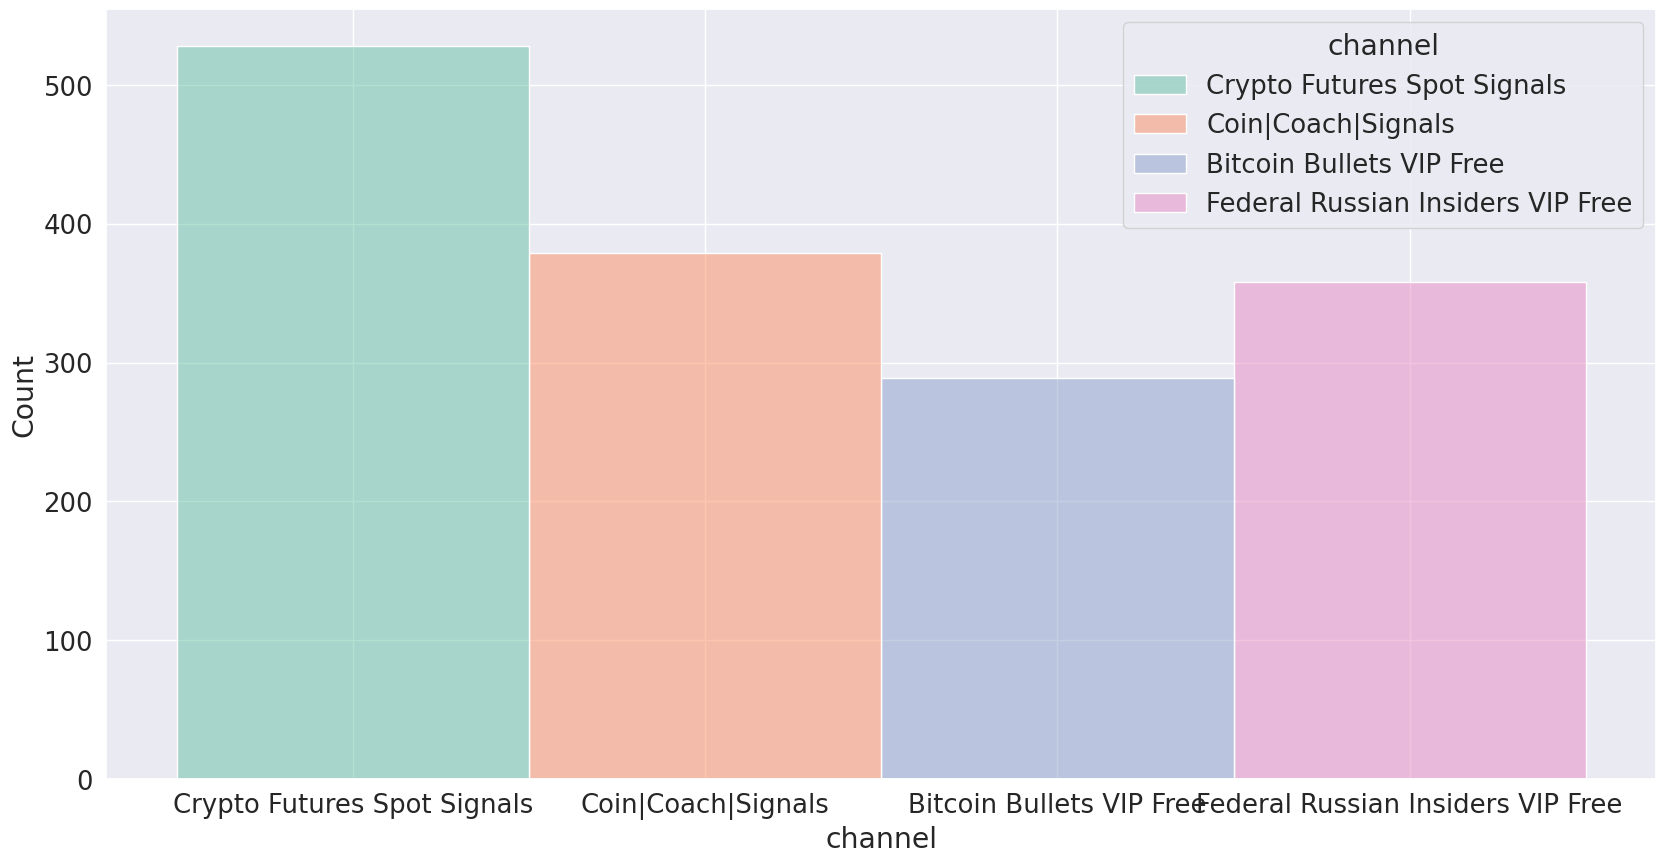

In [ ]:
sns.set(rc={'figure.figsize':(20,10)},font_scale=1.7)
sns.histplot(df_sygnals,x="channel",hue="channel" , palette="Set2")


## eficiencia de señales por canal

In [ ]:
channels=df_sygnals["channel"].unique()
channels

<StringArray>
[      'Crypto Futures Spot Signals',                'Coin|Coach|Signals',
          'Bitcoin Bullets VIP Free', 'Federal Russian Insiders VIP Free']
Length: 4, dtype: string

In [ ]:
efficiency_by_channel=df_sygnals[["channel","efficiency","symbol"]].groupby("channel")

Text(0.5, 1.0, 'Distribucion de eficiencia por canal')

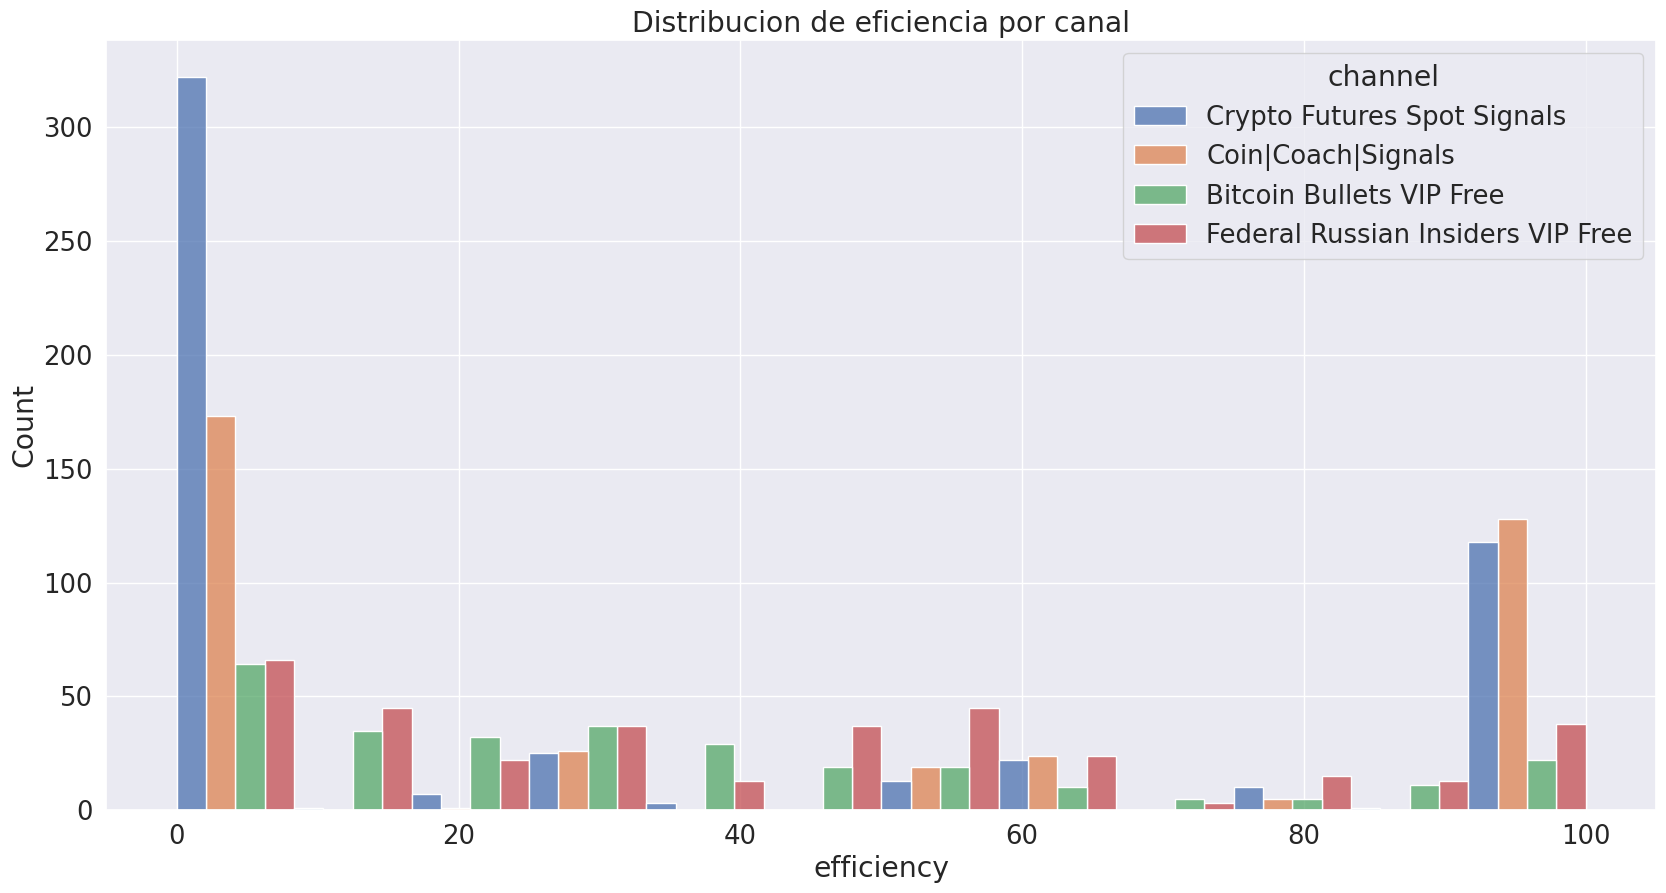

In [ ]:
sns.histplot(df_sygnals, x='efficiency', hue = 'channel', multiple="dodge")
plt.title("Distribucion de eficiencia por canal")


Text(0.5, 1.0, 'Distribucion de eficiencia por canal')

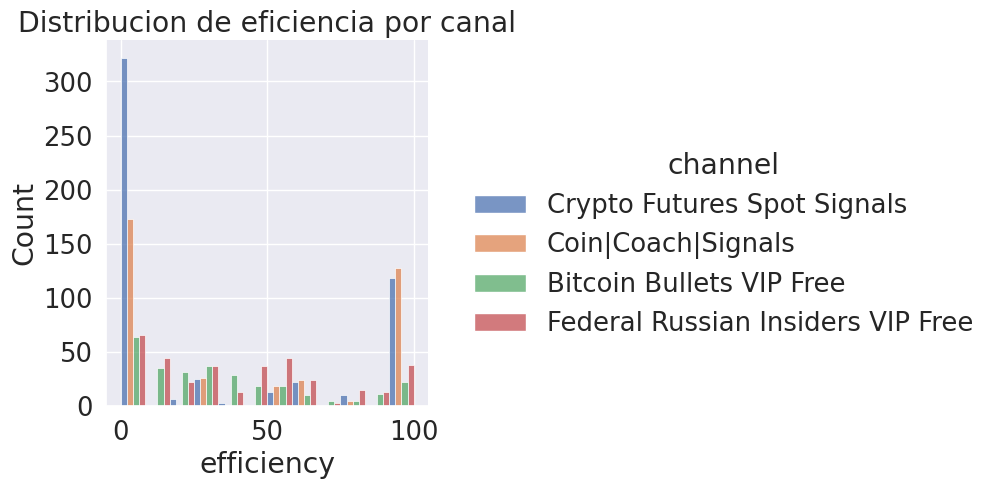

In [ ]:
sns.displot(df_sygnals, x='efficiency', hue = 'channel', multiple="dodge")
plt.title("Distribucion de eficiencia por canal")

## Vistazo de cantidad de operaciones con ganancia y sin ganancia

In [ ]:
is_profit:pd.Series=df_sygnals["efficiency"].dropna().agg(lambda x: "profit" if x > 0 else "no_profit")
is_profit.name="is_profit"

In [ ]:
df_isprofit=pd.concat([df_sygnals[["efficiency","channel","symbol","_id"]],is_profit],axis=1)

Text(0.5, 1.0, 'Distribucion de profit por canal')

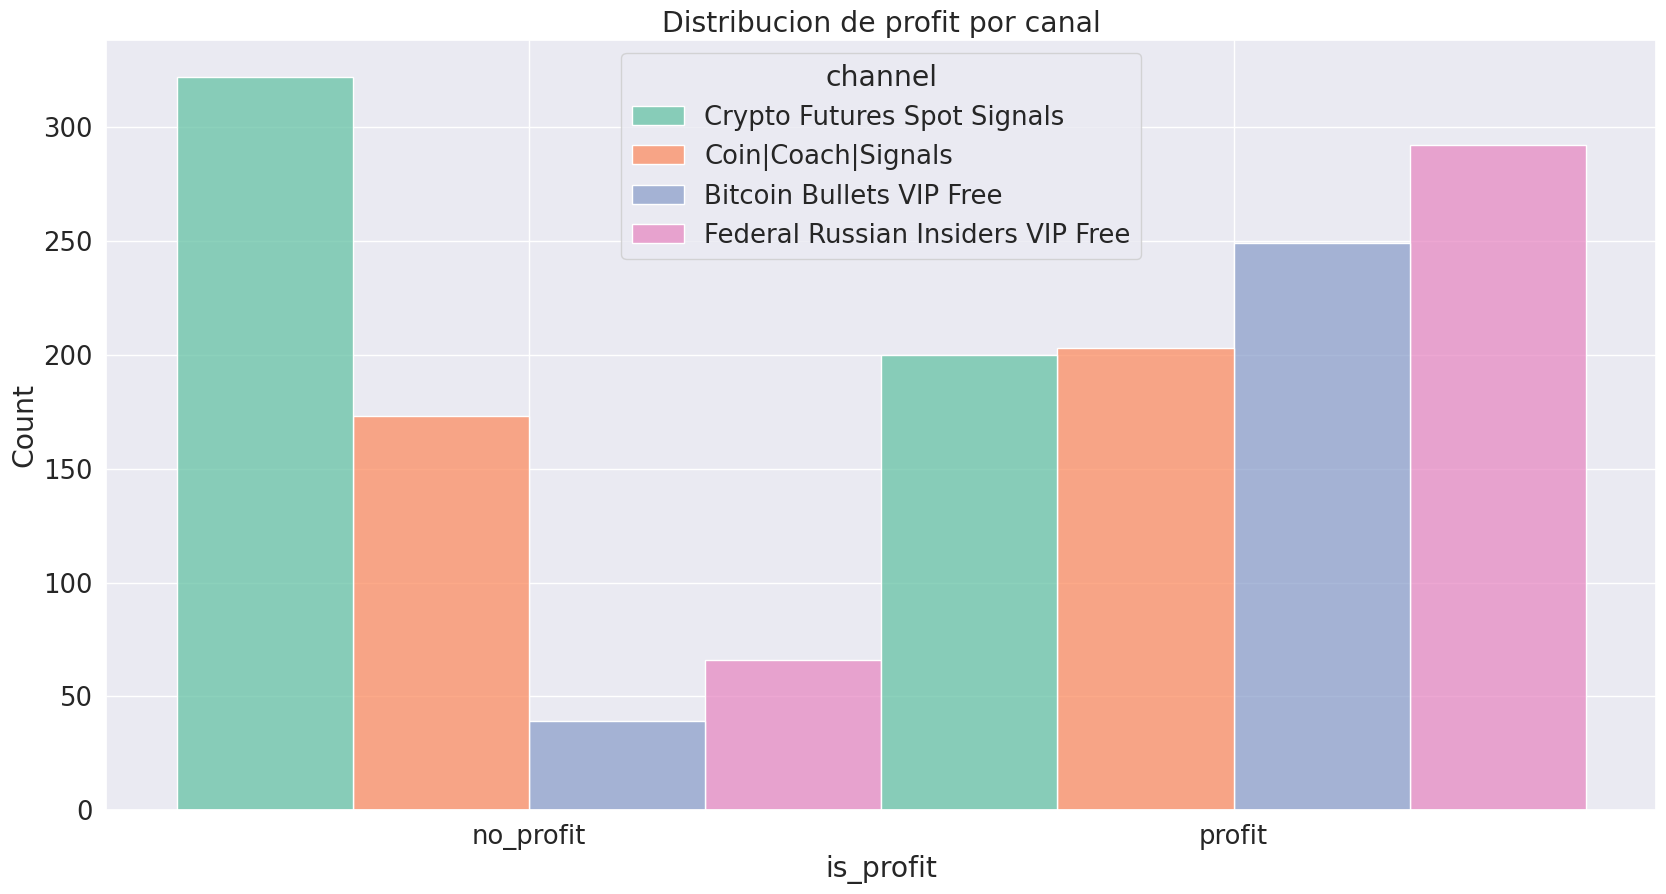

In [ ]:
sns.histplot(df_isprofit, x='is_profit', hue = 'channel', multiple="dodge",palette="Set2")
plt.title("Distribucion de profit por canal")

## Cantidad de operaciones por criptomoneda

### Cantidad de symbolos y pares

In [ ]:
df_sygnals["symbol"].unique()

<StringArray>
[  'BCHUSDT',   'ETHUSDT',   'BTCUSDT',  'BZRXUSDT',  'IOTAUSDT',  'YFIIUSDT',
   'RENUSDT',   'RSRUSDT',   'XRPUSDT',    'ONEBTC',
 ...
   'ANTUSDT',   'ANCUSDT', 'WAVESUSDT',   'BNXUSDT',   'GMTUSDT',  'DASHUSDT',
  'FLOWUSDT', 'JASMYUSDT',   'ENSUSDT',   'INJUSDT']
Length: 242, dtype: string

In [ ]:
df_sygnals.columns

Index(['_id', 'symbol', 'is_long', 'is_entry_market', 'date', 'channel',
       'channel_id', 'message_link', 'dates_entry', 'dates_stoploss',
       'dates_profit', 'efficiency', 'forecast_trend', 'day_value',
       'trend_day', 'error_ta_recomendation', 'error_prophettesting',
       'error_backtesting', 'primary_currencies', 'segundary_currencies',
       'type_leverage', 'is_cross_leverage', 'percent_leverage',
       'percent_trailing_configuration', 'AO', 'RSI', 'ADX', 'CCI20', 'Stoch',
       'first_dates_entry', 'first_dates_stoploss', 'first_dates_profit',
       'changepoint_prior_scale_bp', 'seasonality_prior_scale_bp',
       'seasonality_mode_bp', 'mae_bp', 'rmse_bp', 'mape_bp', 'av_stoploss',
       'av_profit', 'profit_count', 'entry_count'],
      dtype='object')

In [ ]:
df_sygnals['primary_currencies'].unique()


<StringArray>
[   'BCH',    'ETH',    'BTC',   'BZRX',   'IOTA',   'YFII',    'REN',
    'RSR',    'XRP',    'ONE',
 ...
    'KSM',   'CTSI', 'PEOPLE',    'ANC',    'BNX',    'GMT',   'DASH',
   'FLOW',  'JASMY',    'ENS']
Length: 199, dtype: string

In [ ]:
df_sygnals['segundary_currencies'].unique()


<StringArray>
['USDT', 'BTC']
Length: 2, dtype: string

In [ ]:
'Crypto Futures Spot Signals', 'Coin|Coach|Signals', 'Bitcoin Bullets VIP Free', 'Federal Russian Insiders VIP Free'

('Crypto Futures Spot Signals',
 'Coin|Coach|Signals',
 'Bitcoin Bullets VIP Free',
 'Federal Russian Insiders VIP Free')

#### 'Crypto Futures Spot Signals'

/tmp/ipykernel_3281/2707942534.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prf["quantity"]=df_prf.agg(lambda x: (dict(df_prf.value_counts("symbol"))[x["symbol"]]/len(df_prf["symbol"].unique()))*100,axis=1)


cantidad de symbolos 208
cantidad por symbolo symbol
BTCUSDT    43
ETHUSDT    40
LTCUSDT    18
XRPUSDT    10
BNBUSDT    10
SOLUSDT     9
EOSUSDT     8
dtype: int64


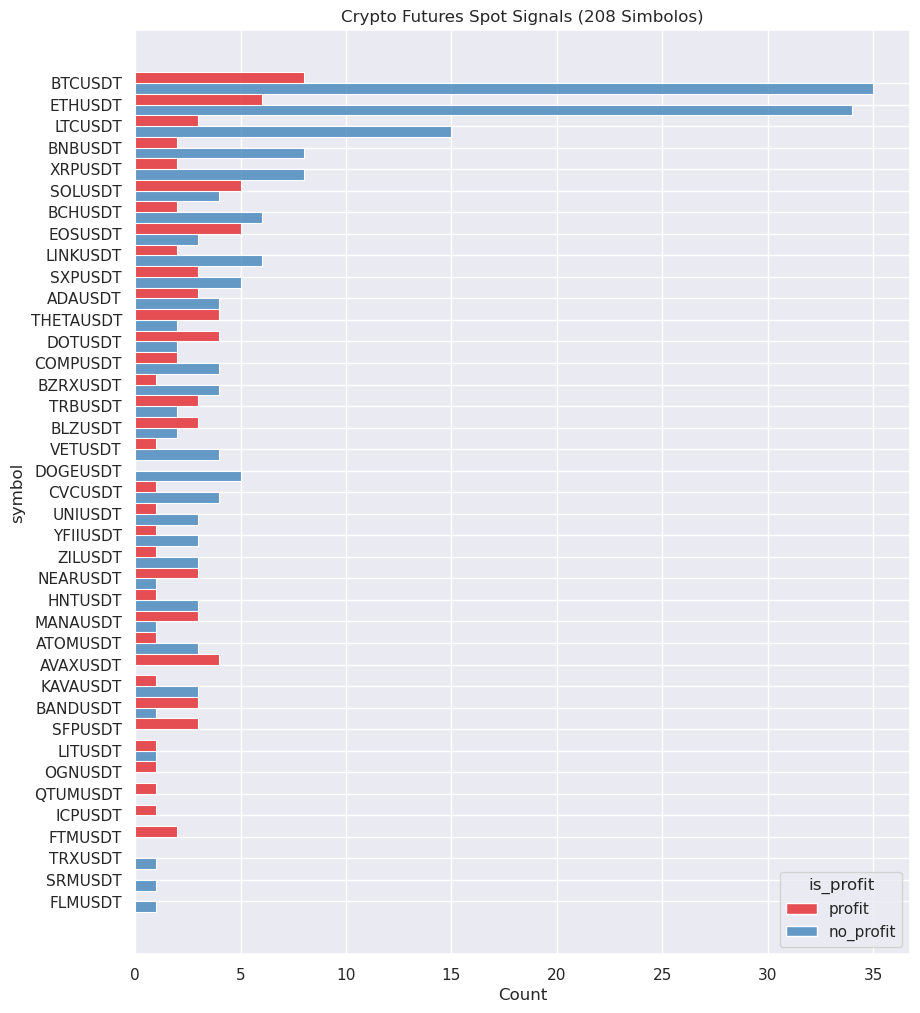

In [ ]:
#construir df para graficar

canal='Crypto Futures Spot Signals'

df_prf=df_isprofit.groupby(["channel"]).get_group(canal)
df_prf["quantity"]=df_prf.agg(lambda x: (dict(df_prf.value_counts("symbol"))[x["symbol"]]/len(df_prf["symbol"].unique()))*100,axis=1)
df_prf.sort_values("quantity",ascending=False)



sns.set(rc={'figure.figsize':(10,12)},font_scale=1)
sns.histplot(df_prf.sort_values("quantity",ascending=False).head(270), y="symbol", hue= 'is_profit', multiple="dodge",palette="Set1")

plt.title(canal+f' ({len(df_prf["symbol"].unique())} Simbolos)')

print(f"""cantidad de symbolos {len(df_prf["symbol"].unique())}""")
print(f"""cantidad por symbolo {df_prf.value_counts("symbol").head(7)}""")


#### 'Coin|Coach|Signals'

/tmp/ipykernel_3281/1136503345.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prf["quantity"]=df_prf.agg(lambda x: (dict(df_prf.value_counts("symbol"))[x["symbol"]]/len(df_prf["symbol"].unique()))*100,axis=1)


cantidad de symbolos 112
cantidad por symbolo symbol
BELUSDT      15
LITUSDT      12
BLZUSDT      11
NKNUSDT      10
ALPHAUSDT    10
CHZUSDT       9
FLMUSDT       9
dtype: int64


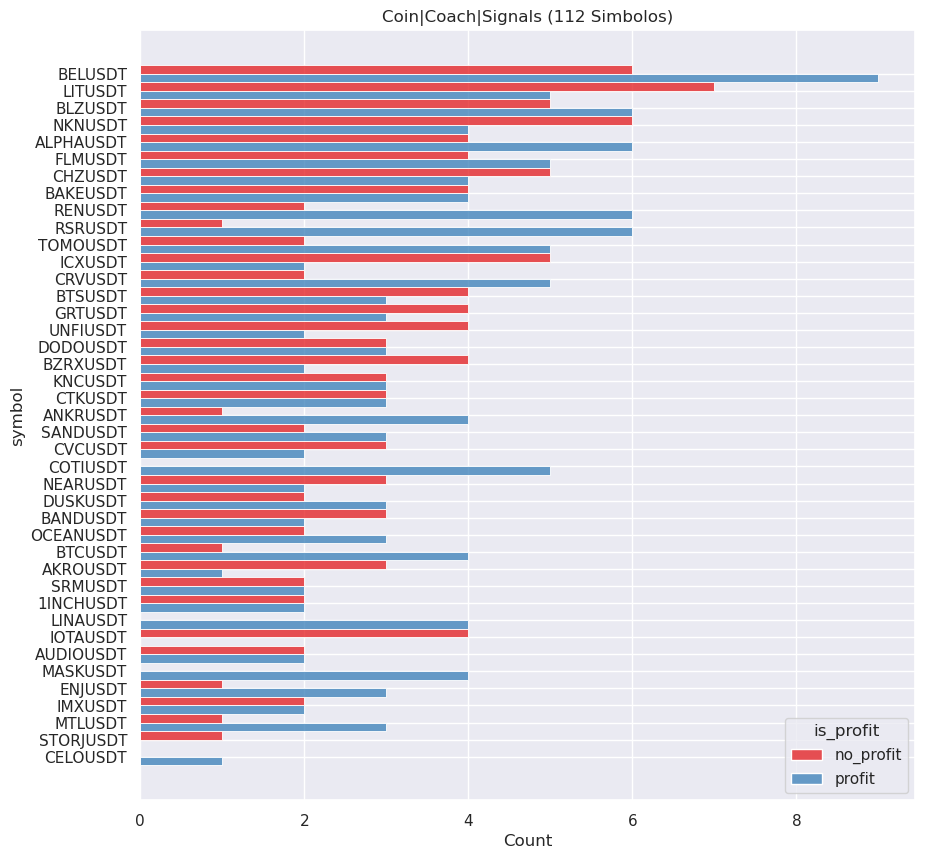

In [ ]:
#construir df para graficar

canal='Coin|Coach|Signals'

df_prf=df_isprofit.groupby(["channel"]).get_group(canal)
df_prf["quantity"]=df_prf.agg(lambda x: (dict(df_prf.value_counts("symbol"))[x["symbol"]]/len(df_prf["symbol"].unique()))*100,axis=1)
df_prf.sort_values("quantity",ascending=False)



sns.set(rc={'figure.figsize':(10,10)},font_scale=1)
sns.histplot(df_prf.sort_values("quantity",ascending=False).head(251), y="symbol", hue= 'is_profit', multiple="dodge",palette="Set1")

plt.title(canal+f' ({len(df_prf["symbol"].unique())} Simbolos)')

print(f"""cantidad de symbolos {len(df_prf["symbol"].unique())}""")
print(f"""cantidad por symbolo {df_prf.value_counts("symbol").head(7)}""")

#### 'Bitcoin Bullets VIP Free'

/tmp/ipykernel_3281/1328059395.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prf["quantity"]=df_prf.agg(lambda x: (dict(df_prf.value_counts("symbol"))[x["symbol"]]/len(df_prf["symbol"].unique()))*100,axis=1)


cantidad de symbolos 65
cantidad por symbolo symbol
AVAXUSDT    17
LTCUSDT     15
ETHUSDT     14
DOTUSDT     11
BNBUSDT     11
DOGEUSDT    10
FILUSDT      9
dtype: int64


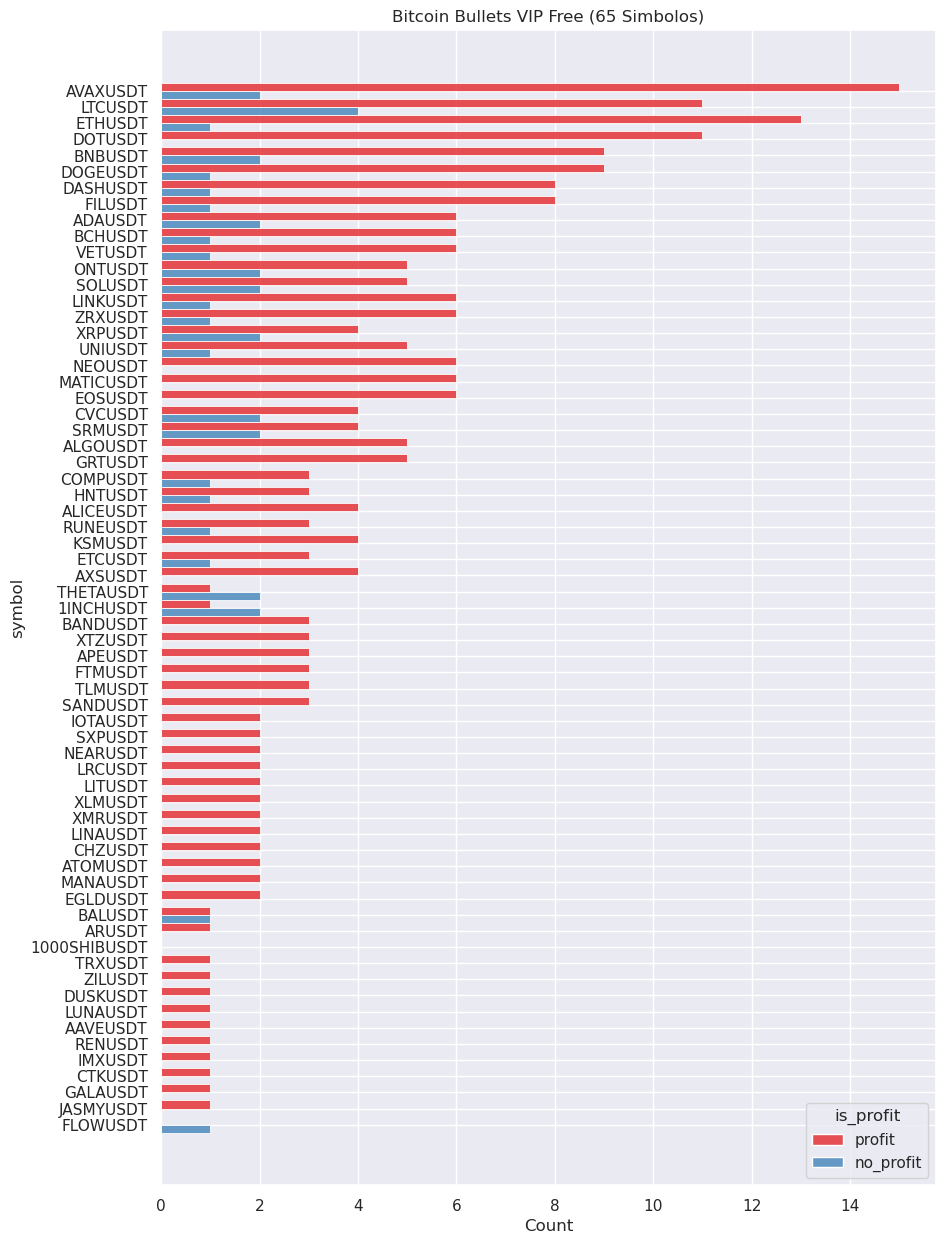

In [ ]:
#construir df para graficar

canal='Bitcoin Bullets VIP Free'

df_prf=df_isprofit.groupby(["channel"]).get_group(canal)
df_prf["quantity"]=df_prf.agg(lambda x: (dict(df_prf.value_counts("symbol"))[x["symbol"]]/len(df_prf["symbol"].unique()))*100,axis=1)
df_prf.sort_values("quantity",ascending=False)



sns.set(rc={'figure.figsize':(10,15)},font_scale=1)
sns.histplot(df_prf.sort_values("quantity",ascending=False), y="symbol", hue= 'is_profit', multiple="dodge",palette="Set1")

plt.title(canal+f' ({len(df_prf["symbol"].unique())} Simbolos)')

print(f"""cantidad de symbolos {len(df_prf["symbol"].unique())}""")
print(f"""cantidad por symbolo {df_prf.value_counts("symbol").head(7)}""")

#### 'Federal Russian Insiders VIP Free'

/tmp/ipykernel_3281/3453393308.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prf["quantity"]=df_prf.agg(lambda x: (dict(df_prf.value_counts("symbol"))[x["symbol"]]/len(df_prf["symbol"].unique()))*100,axis=1)


cantidad de symbolos 68
cantidad por symbolo symbol
ETHUSDT    25
LTCUSDT    18
XRPUSDT    17
ZRXUSDT    14
EOSUSDT    14
XTZUSDT    14
ADAUSDT    13
dtype: int64


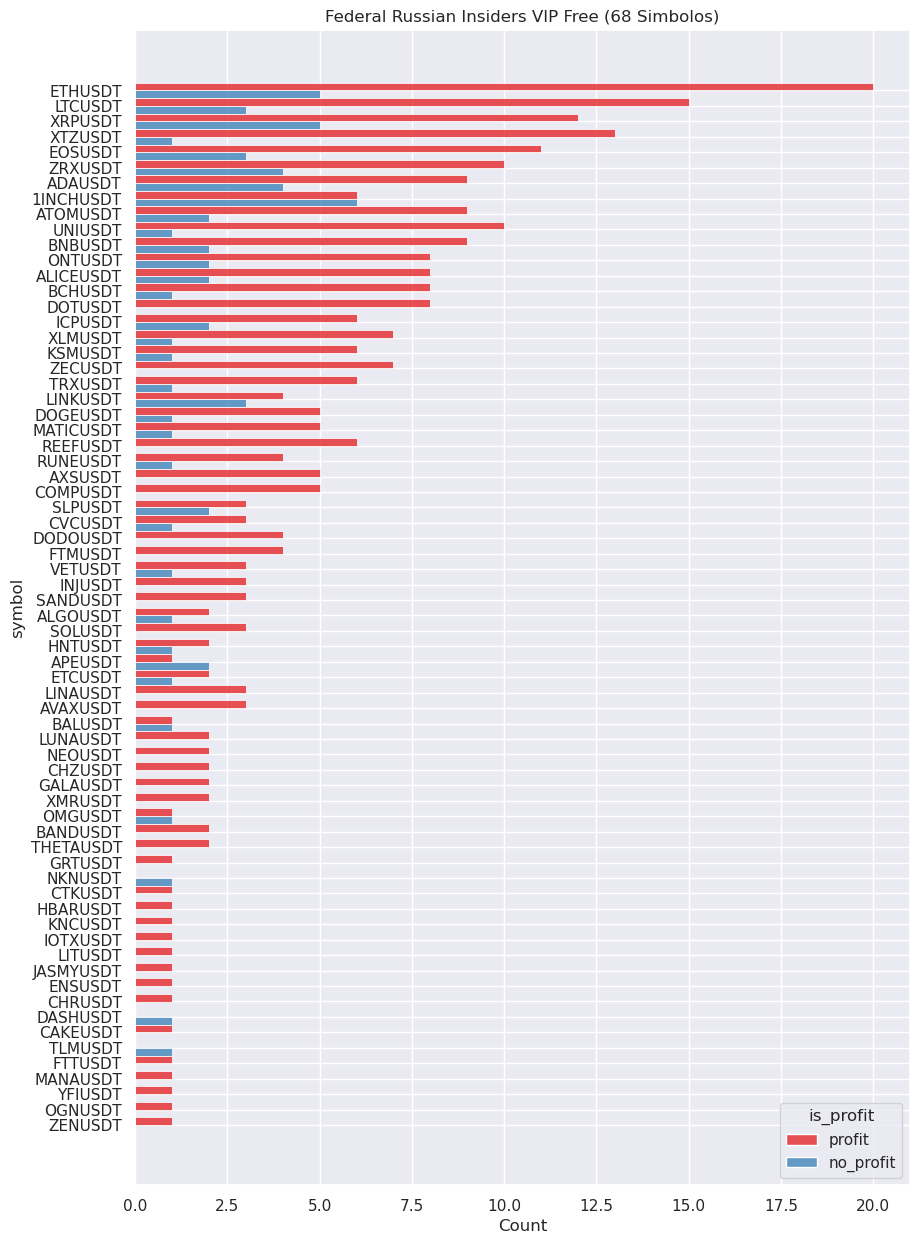

In [ ]:
#construir df para graficar

canal='Federal Russian Insiders VIP Free'

df_prf=df_isprofit.groupby(["channel"]).get_group(canal)
df_prf["quantity"]=df_prf.agg(lambda x: (dict(df_prf.value_counts("symbol"))[x["symbol"]]/len(df_prf["symbol"].unique()))*100,axis=1)
df_prf.sort_values("quantity",ascending=False)



sns.set(rc={'figure.figsize':(10,15)},font_scale=1)
sns.histplot(df_prf.sort_values("quantity",ascending=False), y="symbol", hue= 'is_profit', multiple="dodge",palette="Set1")
plt.title(canal+f' ({len(df_prf["symbol"].unique())} Simbolos)')


print(f"""cantidad de symbolos {len(df_prf["symbol"].unique())}""")
print(f"""cantidad por symbolo {df_prf.value_counts("symbol").head(7)}""")

## variaciones de tiempos segun canal

In [ ]:
df_sygnals.columns,df_sygnals.shape

(Index(['_id', 'symbol', 'is_long', 'is_entry_market', 'date', 'channel',
        'channel_id', 'message_link', 'dates_entry', 'dates_stoploss',
        'dates_profit', 'efficiency', 'forecast_trend', 'day_value',
        'trend_day', 'error_ta_recomendation', 'error_prophettesting',
        'error_backtesting', 'primary_currencies', 'segundary_currencies',
        'type_leverage', 'is_cross_leverage', 'percent_leverage',
        'percent_trailing_configuration', 'AO', 'RSI', 'ADX', 'CCI20', 'Stoch',
        'first_dates_entry', 'first_dates_stoploss', 'first_dates_profit',
        'changepoint_prior_scale_bp', 'seasonality_prior_scale_bp',
        'seasonality_mode_bp', 'mae_bp', 'rmse_bp', 'mape_bp', 'av_stoploss',
        'av_profit', 'profit_count', 'entry_count'],
       dtype='object'),
 (1554, 42))

In [ ]:
df_isprofit.columns,df_isprofit["channel"].unique()

(Index(['efficiency', 'channel', 'symbol', '_id', 'is_profit'], dtype='object'),
 <StringArray>
 [      'Crypto Futures Spot Signals',                'Coin|Coach|Signals',
           'Bitcoin Bullets VIP Free', 'Federal Russian Insiders VIP Free']
 Length: 4, dtype: string)

In [ ]:
df_times.columns,df_times.shape

(Index(['date', 'first_dates_profit', 'first_dates_stoploss',
        'first_dates_entry', 'd_e', 'd_p', 'e_p', 'd_s'],
       dtype='object'),
 (1554, 8))

In [ ]:
def delta_time_ca(x):
    return str(timedelta(seconds=x))

In [ ]:
df_sygnals_2=pd.concat([df_isprofit,df_times],axis=1)

In [ ]:
df_sygnals_2[['d_e', 'd_p', 'e_p', 'd_s']]=df_sygnals_2[['d_e', 'd_p', 'e_p', 'd_s']].transform(lambda x: x/3600,axis=1).astype(int)


In [ ]:
df_sygnals_2_group=df_sygnals_2.groupby(["channel","is_profit"])

In [ ]:
profit_type=df_sygnals_2["is_profit"].dropna().unique()

In [ ]:
df_sygnals_2_group.get_group((channels[0],profit_type[1])).value_counts("d_s").head(7),df_sygnals_2_group.get_group((channels[0],profit_type[0])).value_counts("d_e").head(7)

(d_s
 0      7
 6      5
 372    4
 4      3
 25     3
 69     3
 174    2
 dtype: int64,
 d_e
 0      295
 1        7
 2        5
 12       2
 42       1
 441      1
 273      1
 dtype: int64)

In [ ]:
mask=(df_sygnals_2["is_profit"]=="profit") & (df_sygnals_2["channel"]=="Crypto Futures Spot Signals") & (df_times["d_e"]!=False)& (df_times["d_p"]!=False) & (df_times["e_p"]!=False) & (df_times["d_s"]!=False)
df_sygnals_2[mask][['d_e', 'd_p', 'e_p', 'd_s']].apply([max,min,np.mean, np.median]).apply(lambda x : list(map(delta_time_ca,x)) )

,d_e,d_p,e_p,d_s
max,0:48:49,0:54:19,0:08:23,3:53:43
min,0:00:00,0:00:00,0:00:00,0:00:03
mean,0:00:20.398844,0:00:52.109827,0:00:31.468208,0:12:53.485549
median,0:00:00,0:00:09,0:00:05,0:02:57


In [ ]:
# sns.set(style="darkgrid")

# fig, axs = plt.subplots(2, 2, figsize=(20, 10))

# plt.subplot()

# sns.histplot(data=df_sygnals_2_group.get_group((channels[0],profit_type[1])).value_counts('d_e').sort_values(ascending=False), label=channels[0], color="red", ax=axs[0])
# sns.histplot(data=df_sygnals_2_group.get_group((channels[1],profit_type[1])).value_counts('d_e').sort_values(ascending=False), label=channels[1], color="skyblue", ax=axs[1])
# sns.histplot(data=df_sygnals_2_group.get_group((channels[2],profit_type[1])).value_counts('d_e').sort_values(ascending=False), label=channels[2], color="olive", ax=axs[2])
# sns.histplot(data=df_sygnals_2_group.get_group((channels[3],profit_type[1])).value_counts('d_e').sort_values(ascending=False), label=channels[3], color="green", ax=axs[3])
# plt.show()

In [ ]:
profit_type[1]

'profit'

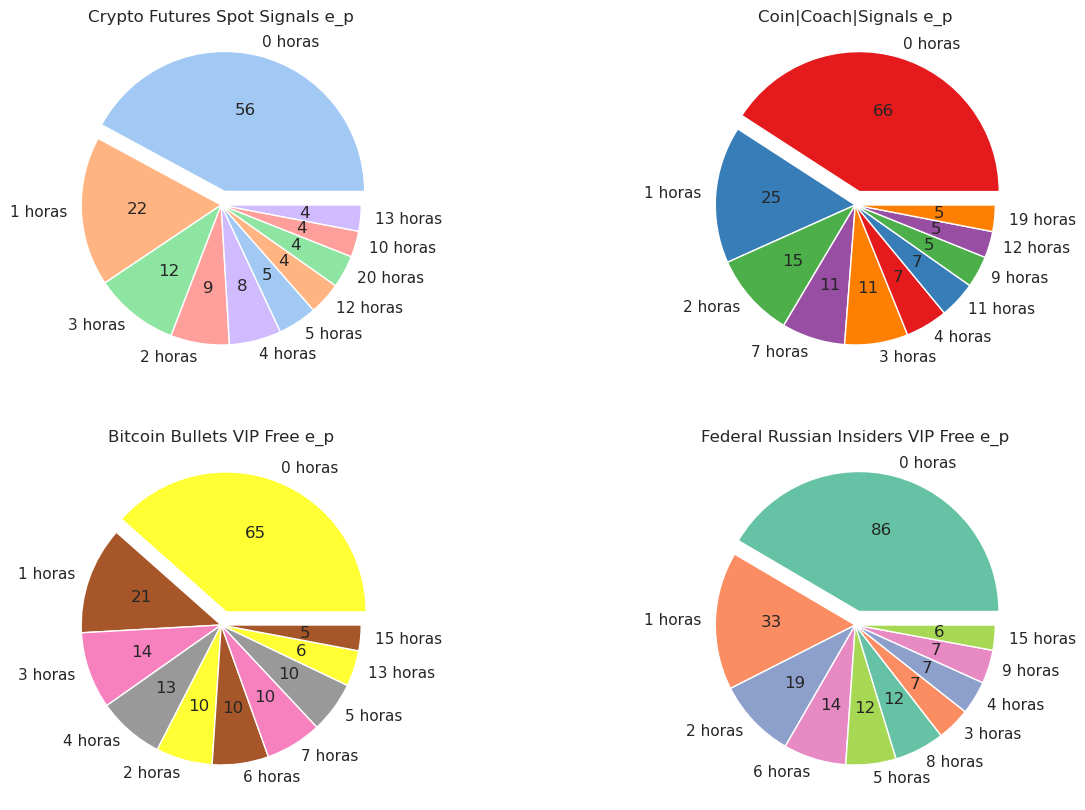

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

length=10
myexplode = [0.1]+[0]*(length-1)

# ---------------- plot 1
plt.subplot(2,2,1)

the_pie=dict(df_sygnals_2_group.get_group((channels[0],profit_type[1])).value_counts('e_p').head(length))
horas=list(map(lambda x: str(x)+" horas",list(the_pie.keys())))
count=list(the_pie.values())

colors = sns.color_palette('pastel')[0:5]
plt.pie(x=count, labels = horas, colors = colors, explode=myexplode, autopct= lambda x: int(x / 100.*np.sum(count)))
plt.title(channels[0]+" e_p")

# ---------------- plot 2
plt.subplot(2,2,2)

the_pie=dict(df_sygnals_2_group.get_group((channels[1],profit_type[1])).value_counts('e_p').head(length))
horas=list(map(lambda x: str(x)+" horas",list(the_pie.keys())))
count=list(the_pie.values())

colors = sns.color_palette('Set1')[0:5]
plt.pie(x=count, labels = horas, colors = colors, explode=myexplode, autopct= lambda x: int(x / 100.*np.sum(count)))
plt.title(channels[1]+" e_p")

# ---------------- plot 3

plt.subplot(2,2,3)

the_pie=dict(df_sygnals_2_group.get_group((channels[2],profit_type[1])).value_counts('e_p').head(length))
horas=list(map(lambda x: str(x)+" horas",list(the_pie.keys())))
count=list(the_pie.values())

colors = sns.color_palette('Set1')[5:10]
plt.pie(x=count, labels = horas, colors = colors, explode=myexplode, autopct= lambda x: int(x / 100.*np.sum(count)))
plt.title(channels[2]+" e_p")

# ---------------- plot 4

plt.subplot(2,2,4)

the_pie=dict(df_sygnals_2_group.get_group((channels[3],profit_type[1])).value_counts('e_p').head(length))
horas=list(map(lambda x: str(x)+" horas",list(the_pie.keys())))
count=list(the_pie.values())

colors = sns.color_palette('Set2')[0:5]
plt.pie(x=count, labels = horas, colors = colors, explode=myexplode, autopct= lambda x: int(x / 100.*np.sum(count)))
plt.title(channels[3]+" e_p")

plt.show()



In [ ]:
# sns.set(rc={'figure.figsize':(10,5)},font_scale=1)
# sns.histplot(data=dict(df_sygnals_2_group.get_group((channels[0],profit_type[1])).value_counts('d_e')))
# plt.title("Tiempo entre publicacion y primera entrada (h)")
# plt.xlabel("horas")

In [ ]:
# sns.set(rc={'figure.figsize':(10,5)},font_scale=1)
# sns.histplot(df_sygnals_2[mask][['d_e', 'd_p', 'e_p', 'd_s']].transform(lambda x: round(x/3600)).astype(int).value_counts('d_p'))
# plt.title("Tiempo entre publicacion y primera ganancia (h)")
# plt.xlabel("horas")

## activadores por analisis tecnico

In [ ]:
df_sygnals.columns

Index(['_id', 'symbol', 'is_long', 'is_entry_market', 'date', 'channel',
       'channel_id', 'message_link', 'dates_entry', 'dates_stoploss',
       'dates_profit', 'efficiency', 'forecast_trend', 'day_value',
       'trend_day', 'error_ta_recomendation', 'error_prophettesting',
       'error_backtesting', 'primary_currencies', 'segundary_currencies',
       'type_leverage', 'is_cross_leverage', 'percent_leverage',
       'percent_trailing_configuration', 'AO', 'RSI', 'ADX', 'CCI20', 'Stoch',
       'first_dates_entry', 'first_dates_stoploss', 'first_dates_profit',
       'changepoint_prior_scale_bp', 'seasonality_prior_scale_bp',
       'seasonality_mode_bp', 'mae_bp', 'rmse_bp', 'mape_bp', 'av_stoploss',
       'av_profit', 'profit_count', 'entry_count'],
      dtype='object')

In [ ]:
df_isprofit.columns

Index(['efficiency', 'channel', 'symbol', '_id', 'is_profit'], dtype='object')

In [ ]:
df_ta_recomendation=pd.concat([df_sygnals[['error_ta_recomendation','is_long','date','AO', 'RSI', 'ADX', 'CCI20', 'Stoch']],df_isprofit],axis=1)

In [ ]:
def confirm_is_long(x,ta):
    
    #no confirma ninguna tendencia
    y=0
    
    if type(x[ta])!=str:
        return y

    #Si confirma la tendencia que presenta la operación
    if (x["is_long"]==True and x[ta]=="long") or (x["is_long"]==False and x[ta]=="short"):
        y=1

    #confirma la tendencia opuesta de la presentada en la operación
    if (x["is_long"]==True and x[ta]=="short") or (x["is_long"]==False and x[ta]=="long"):
        y=-1
    
    return y

In [ ]:
(~df_ta_recomendation["error_ta_recomendation"].isna()).sum()

72

In [ ]:
mask=(df_ta_recomendation['error_ta_recomendation'].isna())
tas=['AO', 'RSI', 'ADX', 'CCI20', 'Stoch']
for ta in tas:
    df_ta_recomendation[ta+"_confirm_trend"]=df_ta_recomendation[mask][['is_long',"symbol","date",'AO', 'RSI', 'ADX', 'CCI20', 'Stoch','error_ta_recomendation']].agg(lambda x: confirm_is_long(x,ta),axis=1)

In [ ]:
df_ta_recomendation["AO_confirm_trend"].value_counts()

 0.0    1341
 1.0      71
-1.0      70
Name: AO_confirm_trend, dtype: int64

In [ ]:
# df_ta_recomendation[['is_profit',
# 'AO_confirm_trend', 'RSI_confirm_trend', 'ADX_confirm_trend',
# 'CCI20_confirm_trend', 'Stoch_confirm_trend']].groupby(['is_profit','AO_confirm_trend']).count()
pd.concat([df_ta_recomendation[['is_profit','AO_confirm_trend','_id']].groupby(['is_profit','AO_confirm_trend']).count().rename(columns={"_id":'AO_confirm_trend'}),
df_ta_recomendation[['is_profit','RSI_confirm_trend','_id']].groupby(['is_profit','RSI_confirm_trend']).count().rename(columns={"_id":'RSI_confirm_trend'}),
df_ta_recomendation[['is_profit','ADX_confirm_trend','_id']].groupby(['is_profit','ADX_confirm_trend']).count().rename(columns={"_id":'ADX_confirm_trend'}),
df_ta_recomendation[['is_profit','CCI20_confirm_trend','_id']].groupby(['is_profit','CCI20_confirm_trend']).count().rename(columns={"_id":'CCI20_confirm_trend'}),
df_ta_recomendation[['is_profit','Stoch_confirm_trend','_id']].groupby(['is_profit','Stoch_confirm_trend']).count().rename(columns={"_id":'Stoch_confirm_trend'})],axis=1)

AO_confirm_trend  RSI_confirm_trend  ADX_confirm_trend  \
is_profit                                                                
no_profit -1.0                33                 28                 11   
           0.0               522                541                561   
           1.0                27                 13                 10   
profit    -1.0                37                 33                 16   
           0.0               818                833                857   
           1.0                44                 33                 26   

                CCI20_confirm_trend  Stoch_confirm_trend  
is_profit                                                 
no_profit -1.0                   37                   13  
           0.0                  509                  553  
           1.0                   36                   16  
profit    -1.0                   45                   19  
           0.0                  762                  841  
           1.0                   92                   39

In [ ]:
df_ta_recomendation['AO_confirm_trend']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1549    0.0
1550    0.0
1551    0.0
1552    0.0
1553    0.0
Name: AO_confirm_trend, Length: 1554, dtype: float64

#### evaluando el ta_recomendations

In [ ]:
mask=~((df_ta_recomendation['AO_confirm_trend']==0)&(df_ta_recomendation['RSI_confirm_trend']==0)&
(df_ta_recomendation['ADX_confirm_trend']==0)&(df_ta_recomendation['CCI20_confirm_trend']==0)& 
(df_ta_recomendation['Stoch_confirm_trend']==0))
mask2=""
df_multi_tas=df_ta_recomendation[mask][["_id","is_profit",'AO_confirm_trend', 'RSI_confirm_trend', 'ADX_confirm_trend','CCI20_confirm_trend', 'Stoch_confirm_trend']]

In [ ]:
df_multi_tas["sum"]=df_multi_tas[['AO_confirm_trend', 'RSI_confirm_trend', 'ADX_confirm_trend','CCI20_confirm_trend', 'Stoch_confirm_trend']].dropna().sum(axis=1)
mask=(df_multi_tas["sum"]==-3) & (~df_multi_tas.iloc[:,:-2].all(1))
df_multi_tas[mask]


,_id,is_profit,AO_confirm_trend,RSI_confirm_trend,ADX_confirm_trend,CCI20_confirm_trend,Stoch_confirm_trend,sum
121,62ad0f9bad1335e0e3f3b052,no_profit,0.0,-1.0,0.0,-1.0,-1.0,-3.0
313,62ad0fa2ad1335e0e3f3b112,profit,0.0,-1.0,0.0,-1.0,-1.0,-3.0
527,62ad0fc5ad1335e0e3f3b1e8,profit,0.0,-1.0,0.0,-1.0,-1.0,-3.0
1216,62ad11adad1335e0e3f3b49c,profit,0.0,-1.0,0.0,-1.0,-1.0,-3.0


In [ ]:
df_multi_tas[["is_profit","sum","_id"]].groupby(["is_profit","sum"]).count()

_id
is_profit sum      
no_profit -3.0    1
          -2.0   13
          -1.0   82
           0.0   10
           1.0   72
           2.0    8
           3.0    1
profit    -3.0    3
          -2.0   14
          -1.0   96
           0.0   17
           1.0  142
           2.0   30
           3.0    5

## correlacion de proncentaje profit_target y stop target con profit 

In [ ]:
df_av_correlation=pd.concat([df_sygnals[["efficiency",'av_stoploss','av_profit',"channel"]],df_isprofit[["is_profit"]]],axis=1)

Text(0.5, 1.0, 'Federal Russian Insiders VIP Free porcentaje de profit/valor de entrada (correlación)')

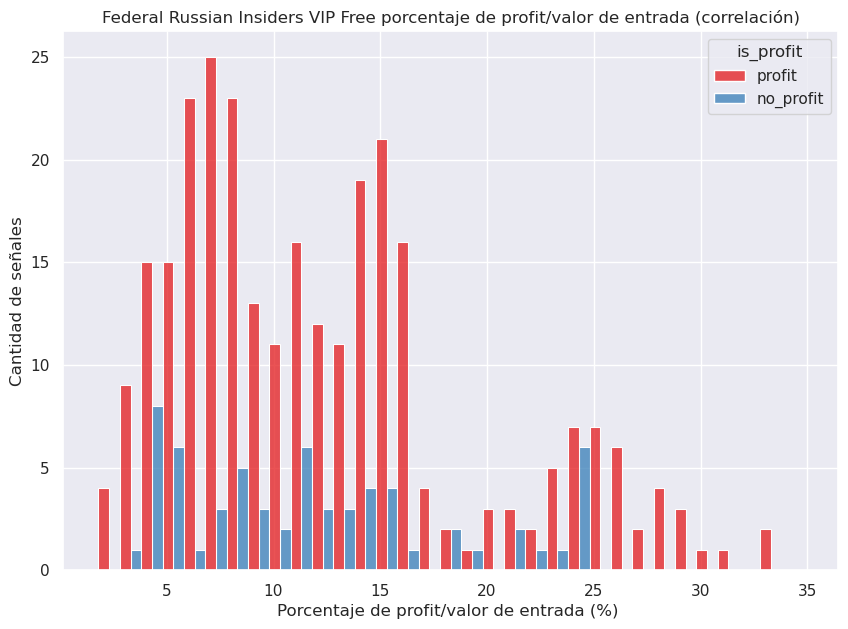

In [ ]:
# number="all"
number=3
evaluate="profit"
# channel="All channels"
channel=channels[number]
sns.set(rc={'figure.figsize':(10,7)},font_scale=1)
mask_channel=df_av_correlation["channel"]==channel

sns.histplot(data=df_av_correlation[mask_channel].sort_values(f"av_{evaluate}").iloc[:-9],palette="Set1",discrete=True,x=f"av_{evaluate}",hue="is_profit", multiple="dodge")
# sns.histplot(data=df_av_correlation.sort_values(f"av_{evaluate}").iloc[:-11],palette="Set1",discrete=True,x=f"av_{evaluate}",hue="is_profit", multiple="dodge")

plt.xlabel(f"Porcentaje de {evaluate}/valor de entrada (%) ")
plt.ylabel(f"Cantidad de señales")
plt.title(f"{channel} porcentaje de {evaluate}/valor de entrada (correlación)")
# plt.savefig(f"porcentaje de {evaluate} correlacion channel {number}.png")

## correlacion de cantidad de profit_targets y entry targets con profit 

In [ ]:
df_count_correlation=pd.concat([df_sygnals[['forecast_trend','trend_day',"is_long",'profit_count','entry_count',"channel"]],df_isprofit[["is_profit"]]],axis=1)

Text(0.5, 1.0, 'All channels cantidad de entry targets (correlación profit)')

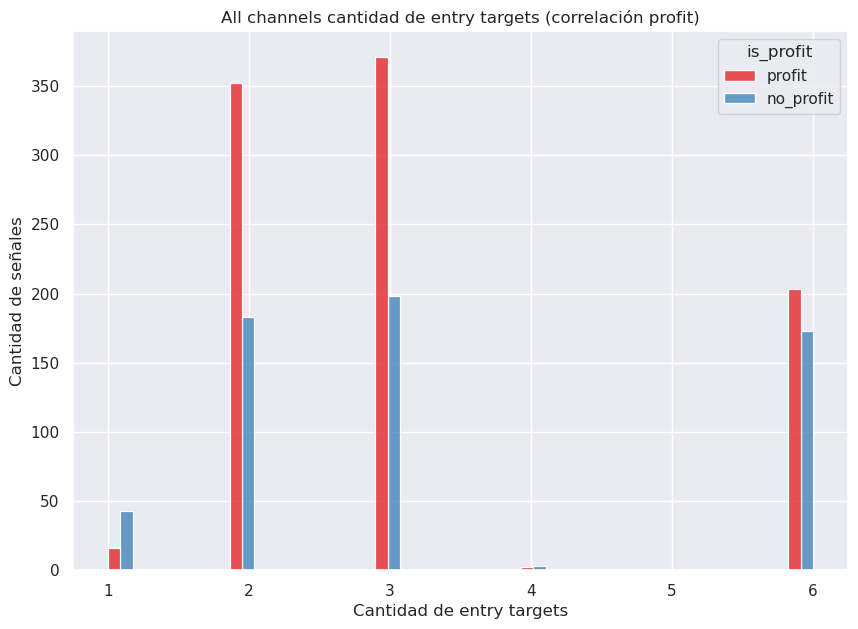

In [ ]:
number="all"
# number=0
evaluate="entry"
channel="All channels"
# channel=channels[number]
sns.set(rc={'figure.figsize':(10,7)},font_scale=1)
mask_channel=df_count_correlation["channel"]==channel

# sns.histplot(data=df_count_correlation[mask_channel].sort_values(f"{evaluate}_count").iloc[:],palette="Set1",discrete=True,x=f"{evaluate}_count",hue="is_profit", multiple="dodge")
sns.histplot(data=df_count_correlation.sort_values(f"{evaluate}_count").iloc[:],palette="Set1",discrete=False,x=f"{evaluate}_count",hue="is_profit", multiple="dodge")

plt.xlabel(f"Cantidad de {evaluate} targets")
plt.ylabel(f"Cantidad de señales")
plt.title(f"{channel} cantidad de {evaluate} targets (correlación profit)")
# plt.savefig(f"cantidad de {evaluate} targets correlacion channel {number}.png")

In [ ]:
df_count_correlation[mask_channel].loc[:,"entry_count"].value_counts()

Series([], Name: entry_count, dtype: Int64)

Text(0.5, 1.0, 'Crypto Futures Spot Signals cantidad de entry targets (correlación profit)')

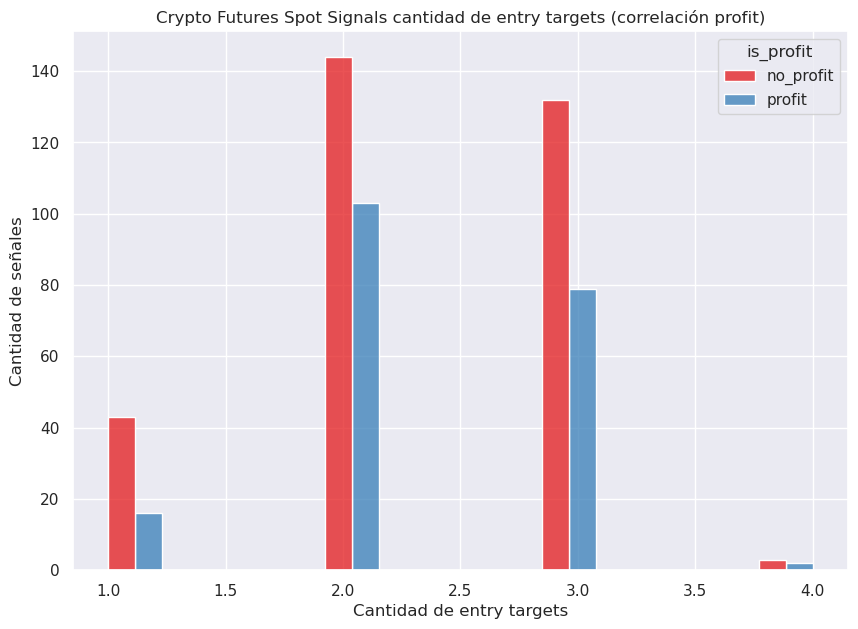

In [ ]:
# number="all"
number=0
evaluate="entry"
# channel="All channels"
channel=channels[number]
sns.set(rc={'figure.figsize':(10,7)},font_scale=1)
mask_channel=df_count_correlation["channel"]==channel

sns.histplot(data=df_count_correlation[mask_channel].sort_values(f"{evaluate}_count").iloc[:],palette="Set1", discrete=False,x=f"{evaluate}_count",hue="is_profit", multiple="dodge")
# sns.histplot(data=df_count_correlation.sort_values(f"{evaluate}_count").iloc[:],palette="Set1",discrete=True,x=f"{evaluate}_count",hue="is_profit", multiple="dodge")

plt.xlabel(f"Cantidad de {evaluate} targets")
plt.ylabel(f"Cantidad de señales")
plt.title(f"{channel} cantidad de {evaluate} targets (correlación profit)")
# plt.savefig(f"cantidad de {evaluate} targets correlacion channel {number}.png")

## Confirmadores de tendencia con Prophet 

In [ ]:
df_count_correlation[['forecast_trend','trend_day',"is_long","is_profit"]].sample(2)

,forecast_trend,trend_day,is_long,is_profit
735,<NA>,<NA>,True,no_profit
1180,long,short,True,profit


In [ ]:
def confirm_is_long(x:pd.Series,trend):
    
    #no confirma ninguna tendencia
    if type(x[trend])!=str:
        return np.nan

    #Si confirma la tendencia que presenta la operación
    if (x["is_long"]==True and x[trend]=="long") or (x["is_long"]==False and x[trend]=="short"):
        y=True

    #confirma la tendencia opuesta de la presentada en la operación
    if (x["is_long"]==True and x[trend]=="short") or (x["is_long"]==False and x[trend]=="long"):
        y=False
    
    return y

In [ ]:
trends=['forecast_trend','trend_day']

for trend in trends:
    df_count_correlation[trend+"_confirm"]=df_count_correlation[['forecast_trend','trend_day',"is_long"]].agg(lambda x: confirm_is_long(x,trend), axis=1)

In [ ]:
df_count_correlation[['forecast_trend_confirm',
       'trend_day_confirm',"is_long","is_profit"]]

,forecast_trend_confirm,trend_day_confirm,is_long,is_profit
0,False,True,True,no_profit
1,False,True,True,no_profit
2,False,False,False,no_profit
3,False,True,False,no_profit
4,NaN,NaN,True,no_profit
...,...,...,...,...
1549,False,True,True,profit
1550,False,False,True,profit
1551,False,False,True,profit
1552,False,False,True,no_profit


# DF for model

### Columnas Usadas

In [ ]:
df_sygnals.columns, df_sygnals.shape
# mucho de los best parameter no entra
# _id, all dates, efficiency, los Ta, no van
# los errors deben usarse para filtrar y ser retirados
# la correlacion de los count suele ser la misma que con los canales, asi que no hacen falta

(Index(['_id', 'symbol', 'is_long', 'is_entry_market', 'date', 'channel',
        'channel_id', 'message_link', 'dates_entry', 'dates_stoploss',
        'dates_profit', 'efficiency', 'forecast_trend', 'day_value',
        'trend_day', 'error_ta_recomendation', 'error_prophettesting',
        'error_backtesting', 'primary_currencies', 'segundary_currencies',
        'type_leverage', 'is_cross_leverage', 'percent_leverage',
        'percent_trailing_configuration', 'AO', 'RSI', 'ADX', 'CCI20', 'Stoch',
        'first_dates_entry', 'first_dates_stoploss', 'first_dates_profit',
        'changepoint_prior_scale_bp', 'seasonality_prior_scale_bp',
        'seasonality_mode_bp', 'mae_bp', 'rmse_bp', 'mape_bp', 'av_stoploss',
        'av_profit', 'profit_count', 'entry_count'],
       dtype='object'),
 (1554, 42))

In [ ]:
# este contiene las salidas a predecir de si hay profit o no si entra
df_isprofit.columns,df_isprofit.shape

(Index(['efficiency', 'channel', 'symbol', '_id', 'is_profit'], dtype='object'),
 (1554, 5))

In [ ]:
# este contiene las confirmaciones de tendencias por los ta si entra
df_multi_tas.columns, df_multi_tas.shape

(Index(['_id', 'is_profit', 'AO_confirm_trend', 'RSI_confirm_trend',
        'ADX_confirm_trend', 'CCI20_confirm_trend', 'Stoch_confirm_trend',
        'sum'],
       dtype='object'),
 (566, 8))

In [ ]:
# Este es solo necesario para ver el tiempo aplicado en el prophet asi que no entra en df_model
df_times.columns, df_times.shape


(Index(['date', 'first_dates_profit', 'first_dates_stoploss',
        'first_dates_entry', 'd_e', 'd_p', 'e_p', 'd_s'],
       dtype='object'),
 (1554, 8))

In [ ]:
# entra lo de confirmaciones por tendencia de prophet
df_count_correlation.columns, df_count_correlation.shape

(Index(['forecast_trend', 'trend_day', 'is_long', 'profit_count', 'entry_count',
        'channel', 'is_profit', 'forecast_trend_confirm', 'trend_day_confirm'],
       dtype='object'),
 (1554, 9))

### El DF formado

In [ ]:
df_for_model=pd.concat([
        df_sygnals[[
        'efficiency', 
        'error_ta_recomendation', 'error_prophettesting','error_backtesting', 
        'is_long', 'is_entry_market', 'channel',
        'primary_currencies', 'segundary_currencies',
        'type_leverage', 'is_cross_leverage', 'percent_leverage',
        'percent_trailing_configuration',
        'av_stoploss','av_profit']],
        df_ta_recomendation[['AO_confirm_trend', 'RSI_confirm_trend',
        'ADX_confirm_trend', 'CCI20_confirm_trend', 'Stoch_confirm_trend']],
        df_count_correlation[['forecast_trend_confirm','trend_day_confirm','profit_count']],
        df_isprofit[["is_profit"]],
        ],axis=1)

In [ ]:
df_for_model.to_csv("data_for_model.csv")

### leer el DF for model

In [ ]:
df_for_model=pd.read_csv("data_for_model.csv",index_col="Unnamed: 0")

### face de transformación y limpieza de los datos

In [ ]:
mask_error=(df_for_model["error_ta_recomendation"].isna()) & (df_for_model["error_prophettesting"].isna()) & (df_for_model["error_backtesting"].isna()) #& (~df_for_model["forecast_trend_confirm"].isna())
df_for_model_clean=df_for_model[mask_error].copy()
df_for_model[mask_error].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1421 entries, 0 to 1553
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   efficiency                      1421 non-null   float64
 1   error_ta_recomendation          0 non-null      object 
 2   error_prophettesting            0 non-null      object 
 3   error_backtesting               0 non-null      object 
 4   is_long                         1421 non-null   bool   
 5   is_entry_market                 1421 non-null   bool   
 6   channel                         1421 non-null   object 
 7   primary_currencies              1421 non-null   object 
 8   segundary_currencies            1421 non-null   object 
 9   type_leverage                   461 non-null    object 
 10  is_cross_leverage               1421 non-null   bool   
 11  percent_leverage                1421 non-null   int64  
 12  percent_trailing_configuration  14

In [ ]:
df_for_model_clean.drop(columns=["error_ta_recomendation",
 "error_prophettesting","error_backtesting"], inplace=True)

In [ ]:
columns=df_for_model_clean.columns
columns

Index(['efficiency', 'is_long', 'is_entry_market', 'channel',
       'primary_currencies', 'segundary_currencies', 'type_leverage',
       'is_cross_leverage', 'percent_leverage',
       'percent_trailing_configuration', 'av_stoploss', 'av_profit',
       'AO_confirm_trend', 'RSI_confirm_trend', 'ADX_confirm_trend',
       'CCI20_confirm_trend', 'Stoch_confirm_trend', 'forecast_trend_confirm',
       'trend_day_confirm', 'profit_count', 'is_profit'],
      dtype='object')

In [ ]:
### corregir los valores del type_leverage
df_for_model_clean["type_leverage"].replace({"Cross":"cross","cross default":"cross",
"Isolated":"isolate","Isolate":"isolate",},inplace=True)

### Selección de datos numericos y pasarlos a categoricos

In [ ]:
i=0
for column in columns:
    print(f"index: {i} {column}, values: {set(df_for_model_clean[column].unique())}")
    i=i+1

index: 0 efficiency, values: {0.0, 5.88235294117647, 6.666666666666667, 7.6923076923076925, 8.333333333333332, 9.090909090909092, 10.0, 6.25, 12.5, 13.333333333333334, 14.285714285714285, 15.384615384615383, 16.666666666666664, 11.76470588235294, 18.181818181818183, 10.526315789473683, 20.0, 21.428571428571427, 22.22222222222222, 23.07692307692308, 23.52941176470588, 25.0, 26.31578947368421, 27.27272727272727, 28.57142857142857, 27.77777777777778, 30.0, 30.76923076923077, 31.25, 33.33333333333333, 29.411764705882355, 35.714285714285715, 36.36363636363637, 36.84210526315789, 38.46153846153847, 38.88888888888889, 40.0, 41.66666666666667, 42.85714285714285, 43.75, 44.44444444444444, 45.45454545454545, 46.15384615384615, 47.368421052631575, 47.05882352941176, 42.10526315789473, 50.0, 52.94117647058824, 53.84615384615385, 53.333333333333336, 55.55555555555556, 57.14285714285714, 58.333333333333336, 60.0, 61.53846153846154, 62.5, 64.70588235294117, 64.28571428571429, 66.66666666666666, 69.23

### Get one-hots

In [ ]:
list(tuple(columns[1:5])+tuple(columns[5:8])+tuple(columns[9:10])+tuple(columns[12:19])+tuple(columns[20:21]))

['is_long',
 'is_entry_market',
 'channel',
 'primary_currencies',
 'segundary_currencies',
 'type_leverage',
 'is_cross_leverage',
 'percent_trailing_configuration',
 'AO_confirm_trend',
 'RSI_confirm_trend',
 'ADX_confirm_trend',
 'CCI20_confirm_trend',
 'Stoch_confirm_trend',
 'forecast_trend_confirm',
 'trend_day_confirm',
 'is_profit']

In [ ]:
#for_one_hot=[columns[16],columns[15],columns[14]]
for_one_hot=list(tuple(columns[1:5])+tuple(columns[5:8])+tuple(columns[9:10])+tuple(columns[12:19])+tuple(columns[20:21]))
df_one_hot=pd.get_dummies(data=df_for_model_clean[for_one_hot],columns=for_one_hot,prefix=for_one_hot).drop(columns=[
"is_profit_no_profit",
"segundary_currencies_BTC",
"is_long_False",
"is_entry_market_False",
"is_cross_leverage_False",
])
df_one_hot

,is_long_True,is_entry_market_True,channel_Bitcoin Bullets VIP Free,channel_Coin|Coach|Signals,channel_Crypto Futures Spot Signals,channel_Federal Russian Insiders VIP Free,primary_currencies_1INCH,primary_currencies_AAVE,primary_currencies_ADA,primary_currencies_ADX,...,CCI20_confirm_trend_0.0,CCI20_confirm_trend_1.0,Stoch_confirm_trend_-1.0,Stoch_confirm_trend_0.0,Stoch_confirm_trend_1.0,forecast_trend_confirm_False,forecast_trend_confirm_True,trend_day_confirm_False,trend_day_confirm_True,is_profit_profit
0,1,0,0,0,1,0,0,0,0,0,...,0,1,0,1,0,1,0,0,1,0
1,1,0,0,0,1,0,0,0,0,0,...,1,0,0,1,0,1,0,0,1,0
5,1,1,0,0,1,0,0,0,0,0,...,1,0,0,1,0,0,1,1,0,0
6,1,1,0,0,1,0,0,0,0,0,...,1,0,0,1,0,0,1,0,1,1
7,1,1,0,0,1,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1549,1,1,0,0,0,1,1,0,0,0,...,0,1,0,1,0,1,0,0,1,1
1550,1,1,0,0,0,1,0,0,0,0,...,0,1,0,1,0,1,0,1,0,1
1551,1,1,0,0,0,1,0,0,0,0,...,1,0,0,1,0,1,0,1,0,1
1552,1,1,0,0,0,1,0,0,0,0,...,1,0,0,1,0,1,0,1,0,0


### Categorization of number data

In [ ]:
# set(columns)-set(for_one_hot)-{'efficiency'}
for_cate=list(set(columns)-set(for_one_hot)-{'efficiency','primary_currencies','is_profit'})
for_cate

['profit_count', 'percent_leverage', 'av_stoploss', 'av_profit']

#### Ajustes

In [ ]:
i=0
df_temp=pd.cut(
    df_for_model_clean[for_cate[i]],
    bins=[0,1,3,5,10,15,df_for_model_clean[for_cate[i]].max()]
    )
print(f"{for_cate[i]}")
df_temp.value_counts()

profit_count


(1, 3]      479
(5, 10]     388
(3, 5]      306
(10, 15]    138
(15, 21]     84
(0, 1]       26
Name: profit_count, dtype: int64

In [ ]:
i=1
df_temp=pd.cut(
    df_for_model_clean[for_cate[i]],
    bins=[0,4,5,10,15,df_for_model_clean[for_cate[i]].max()]
    )
print(f"{for_cate[i]}")
df_temp.value_counts()

percent_leverage


(4, 5]       1175
(15, 100]     131
(5, 10]        89
(0, 4]         18
(10, 15]        8
Name: percent_leverage, dtype: int64

In [ ]:
i=2
df_temp=pd.cut(
    df_for_model_clean[for_cate[i]],
    bins=[0,2,4,8,10,15,df_for_model_clean[for_cate[i]].max()]
    )
print(f"{for_cate[i]}")
df_temp.value_counts()

av_stoploss


(2.0, 4.0]       451
(4.0, 8.0]       383
(10.0, 15.0]     178
(8.0, 10.0]      175
(0.0, 2.0]       124
(15.0, 798.5]    110
Name: av_stoploss, dtype: int64

In [ ]:
i=3
df_temp=pd.cut(
    df_for_model_clean[for_cate[i]],
    bins=[0,2,5,10,15,25,35,df_for_model_clean[for_cate[i]].max()]
    )
print(f"{for_cate[i]}")
df_temp.value_counts()

av_profit


(5.0, 10.0]      425
(2.0, 5.0]       400
(10.0, 15.0]     218
(15.0, 25.0]     195
(0.0, 2.0]        75
(25.0, 35.0]      64
(35.0, 914.8]     44
Name: av_profit, dtype: int64

#### concatenado

In [ ]:
for_categorical=pd.concat([pd.cut(
    df_for_model_clean[for_cate[0]],
    bins=[0,1,3,5,10,15,df_for_model_clean[for_cate[0]].max()]
    ),
    pd.cut(
    df_for_model_clean[for_cate[1]],
    bins=[0,4,5,10,15,df_for_model_clean[for_cate[1]].max()]
    ),
    pd.cut(
    df_for_model_clean[for_cate[2]],
    bins=[0,2,4,8,10,15,df_for_model_clean[for_cate[2]].max()]
    ),
    pd.cut(
    df_for_model_clean[for_cate[3]],
    bins=[0,2,5,10,15,25,35,df_for_model_clean[for_cate[3]].max()]
    )
    ],axis=1,)

In [ ]:

df_for_categorical=pd.get_dummies(data=for_categorical[for_cate],columns=for_cate,prefix=for_cate,)

df_for_categorical.columns
df_for_categorical.columns=[
    'percent_leverage_0to1',
    'percent_leverage_1to3',
       'percent_leverage_3to5',
        'percent_leverage_5to10',
       'percent_leverage_10to15',
        'percent_leverage_15to100',
       'profit_count_0to4',
       'profit_count_4to5',
       'profit_count_5to10',
        'profit_count_10to15',
       'profit_count_15to21',
              'av_profit_0.0to2.0',
       'av_profit_2.0to4.0',
       'av_profit_4.0to8.0',
              'av_profit_8.0to10.0',
       'av_profit_10.0to15.0',
              'av_profit_15.0to914.8',
       'av_stoploss_0.0to2.0',
              'av_stoploss_2.0to5.0',
       'av_stoploss_5.0to10.0',
              'av_stoploss_10.0to15.0',
       'av_stoploss_15.0to25.0',
              'av_stoploss_25.0to35.0',
       'av_stoploss_35.0to798.5']
df_for_categorical

,percent_leverage_0to1,percent_leverage_1to3,percent_leverage_3to5,percent_leverage_5to10,percent_leverage_10to15,percent_leverage_15to100,profit_count_0to4,profit_count_4to5,profit_count_5to10,profit_count_10to15,...,av_profit_8.0to10.0,av_profit_10.0to15.0,av_profit_15.0to914.8,av_stoploss_0.0to2.0,av_stoploss_2.0to5.0,av_stoploss_5.0to10.0,av_stoploss_10.0to15.0,av_stoploss_15.0to25.0,av_stoploss_25.0to35.0,av_stoploss_35.0to798.5
0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
5,0,0,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
6,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
7,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1549,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
1550,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
1551,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
1552,0,0,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0


### Training data

In [ ]:
####pasar el currencie a categorical

df_for_model_clean.primary_currencies=df_for_model_clean.primary_currencies.astype("category")

In [ ]:
#valores independientes
X=pd.concat([
df_for_categorical,
df_one_hot.drop(columns="is_profit_profit"),
],
axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1421 entries, 0 to 1553
Columns: 246 entries, percent_leverage_0to1 to trend_day_confirm_True
dtypes: uint8(246)
memory usage: 352.5 KB


In [ ]:
#valores idependientes
Y=df_one_hot["is_profit_profit"]

### Entrenar el modelo

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer, confusion_matrix, plot_confusion_matrix


In [ ]:
sum(Y)/len(Y) # El 62% de las operaciones tienen ganancia

0.6220971147079521

In [ ]:
# dividir los datos en test, train
X_train,X_test,Y_train,Y_test= train_test_split(X,Y,random_state=42,stratify=Y)


In [ ]:
#Mantenemos proporciones
sum(Y_test)/len(Y_test)

0.6207865168539326

In [ ]:
#Mantenemos proporciones
sum(Y_train)/len(Y_train)

0.6225352112676056

In [ ]:
# columns=X.columns
# i=0
# for column in columns:
#     print(f"index: {i} {column}, values: {set(X[column].unique())}")
#     i=i+1

In [ ]:
# entrenar
clf_xgb=xgb.XGBClassifier(objective="binary:logistic", seed=42)

In [ ]:
clf_xgb.fit(
    X_train,
    Y_train,
    verbose=True,
    early_stopping_rounds=10,
    eval_metric="aucpr",
    eval_set=[(
        X_test,
        Y_test,
    )]
)

[0]	validation_0-aucpr:0.78592
[1]	validation_0-aucpr:0.79306
[2]	validation_0-aucpr:0.79091
[3]	validation_0-aucpr:0.78991
[4]	validation_0-aucpr:0.79570
[5]	validation_0-aucpr:0.79876


/home/joan/anaconda3/envs/pasanti_venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/joan/anaconda3/envs/pasanti_venv/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[6]	validation_0-aucpr:0.80843
[7]	validation_0-aucpr:0.81300
[8]	validation_0-aucpr:0.81917
[9]	validation_0-aucpr:0.82120
[10]	validation_0-aucpr:0.82320
[11]	validation_0-aucpr:0.82438
[12]	validation_0-aucpr:0.82012
[13]	validation_0-aucpr:0.82035
[14]	validation_0-aucpr:0.82383
[15]	validation_0-aucpr:0.82352
[16]	validation_0-aucpr:0.82113
[17]	validation_0-aucpr:0.82147
[18]	validation_0-aucpr:0.81986
[19]	validation_0-aucpr:0.82220
[20]	validation_0-aucpr:0.82267
[21]	validation_0-aucpr:0.82119


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [ ]:
clf_xgb.fit(
    X_train,
    Y_train,
    verbose=False,
    early_stopping_rounds=10000,
    eval_metric="aucpr",
    eval_set=[(
        X_test,
        Y_test,
    )])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [ ]:
Ypredict=clf_xgb.predict(X_test)

/home/joan/anaconda3/envs/pasanti_venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


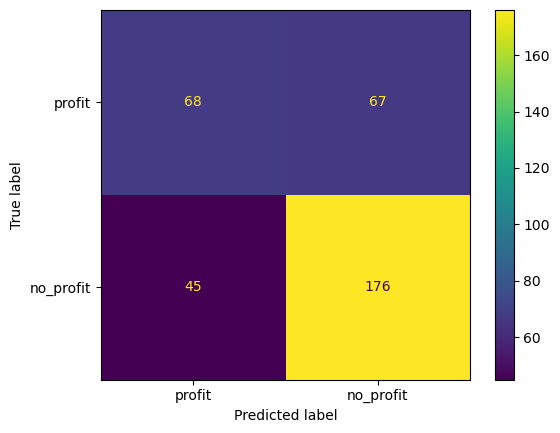

In [ ]:
plt.rcdefaults()
plot_confusion_matrix(
    clf_xgb,
    X_test,
    Y_test,
    values_format="d",
    display_labels=[
        "profit",
        "no_profit"
    ]

)

In [ ]:
balanced_accuracy_score(y_pred=Ypredict,y_true=Y_test)

0.6500418971007206

### Obtener el mejor parametro

In [ ]:
# Round 1

param_grid1={
    "max_depth":[4],
    "learning_rate":[0.1,0.5,1],
    "gamma":[0.25],
    "reg_lambda":[10,20,100],
    "scale_pos_weight":[3]
}

In [ ]:
# Round 2
param_grid2={
    "max_depth":[3,4,5],
    "learning_rate":[0.1,0.01,0.5],
    "gamma":[0,0.25,1],
    "reg_lambda":[0,1.0,10.0],
    "scale_pos_weight":[1,3,5]
}

In [ ]:
optimal_params=GridSearchCV(
    estimator=xgb.XGBClassifier(
        subsample=0.9,
        colsample_bytree=0.5,
        objective="binary:logistic", 
        seed=42,
        ),
    param_grid=param_grid2,
    scoring="roc_auc",
    verbose=0,
    n_jobs=10,
    cv=3
)

In [ ]:
optimal_params.fit(
    X_train,
    Y_train,
    verbose=False,
    early_stopping_rounds=10,
    eval_metric="auc",
    eval_set=[(
        X_test,
        Y_test,
    )])

In [ ]:
print(optimal_params.best_params_)
print(optimal_params.best_score_)

{'gamma': 0, 'learning_rate': 0.5, 'max_depth': 3, 'reg_lambda': 1.0, 'scale_pos_weight': 1}
0.7665012043853133


In [ ]:
print(optimal_params.best_params_)
print(optimal_params.best_score_)

{'gamma': 0.25, 'learning_rate': 0.5, 'max_depth': 4, 'reg_lambda': 100, 'scale_pos_weight': 3}
0.7591510771932194


### Implementear los mejores parametros

In [ ]:
params={'gamma': 0, 
        'learning_rate': 0.5, 
        'max_depth': 3, 
        'reg_lambda': 1.0, 
        'scale_pos_weight': 1,
        "subsample":0.9,
        "colsample_bytree":0.5,
        "objective":"binary:logistic", 
        "seed":42,
        }
clf_xgb=xgb.XGBClassifier(**params)

clf_xgb.fit(
    
    X_train,
    Y_train,
    verbose=False,
    early_stopping_rounds=100,
    eval_metric="aucpr",
    eval_set=[(
        X_test,
        Y_test,
    )]
)

Y_predict=clf_xgb.predict(X_test)

/home/joan/anaconda3/envs/pasanti_venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/joan/anaconda3/envs/pasanti_venv/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [ ]:
feature_importances=pd.concat([pd.Series(X.columns),pd.Series(clf_xgb.feature_importances_)],axis=1)
mask=feature_importances.iloc[:,1]>0
feature_importances[mask].sort_values(1).tail()

,0,1
222,type_leverage_cross,0.017199
224,is_cross_leverage_True,0.018433
26,channel_Bitcoin Bullets VIP Free,0.021796
28,channel_Crypto Futures Spot Signals,0.143030
226,percent_trailing_configuration_5,0.172906


/home/joan/anaconda3/envs/pasanti_venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


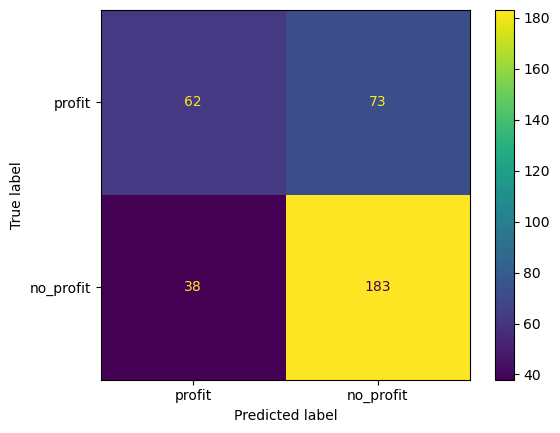

In [ ]:
plt.rcdefaults()
plot_confusion_matrix(
    clf_xgb,
    X_test,
    Y_test,
    values_format="d",
    display_labels=[
        "profit",
        "no_profit"
    ]

)

In [ ]:
roc_auc_score(Y_test,Y_predict)

0.6436567789508966

In [377]:
# dividir los datos en test, train
# entrenar
# comparar resultados


In [418]:
weeks18=pd.to_datetime("22/march/2022")+timedelta(weeks=18)
weeks18

Timestamp('2022-07-26 00:00:00')